In [1]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
import os
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

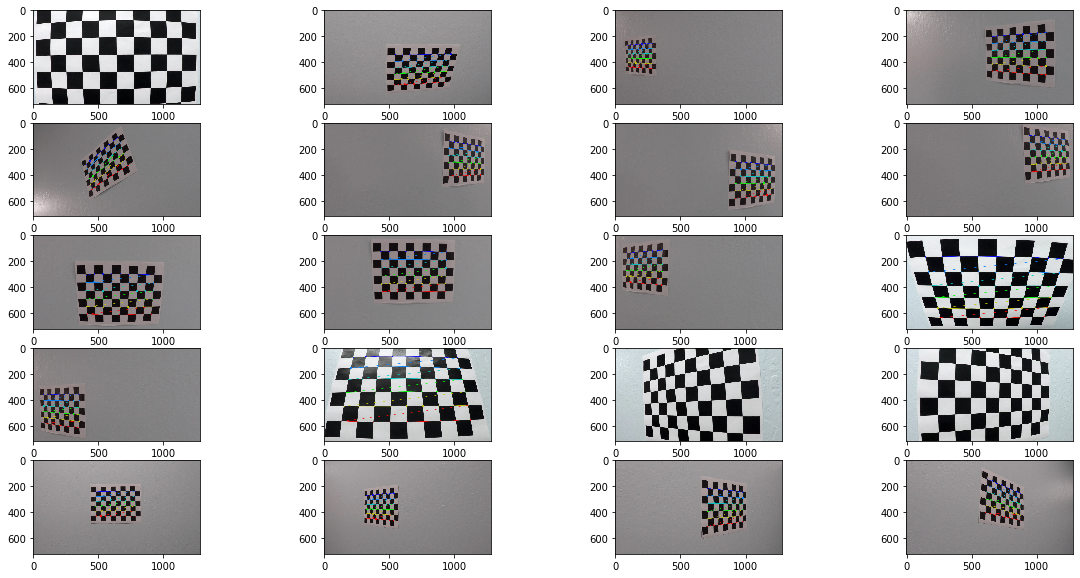

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
fig=plt.figure(figsize=(20,10))
i=0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    i+=1

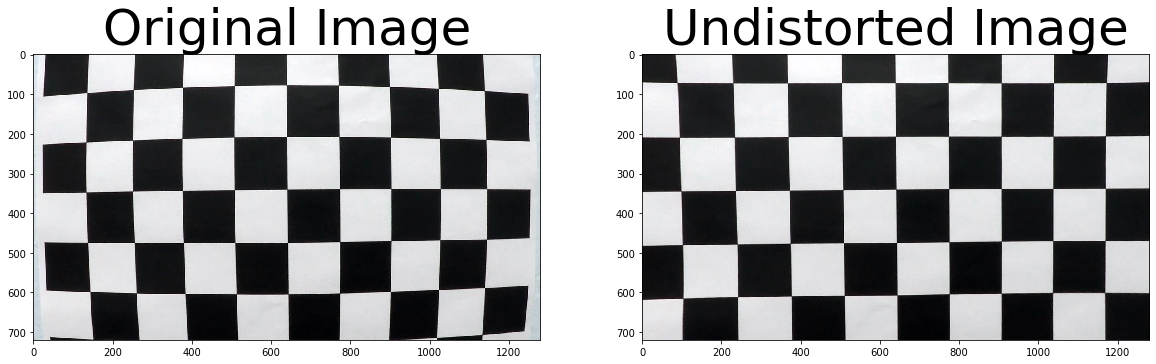

In [4]:
# Now let's test calibration
img = cv2.imread('./camera_cal/calibration1.jpg')

# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

#Undistorting a test image:
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image', fontsize=50)
plt.imshow(dst)
plt.savefig('output_images/undistort_output.png',dpi=100);

In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = np.array([], dtype='int')  
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # Polynomial coefficients of the last n fits of the line
        self.recent_fit = np.array([], dtype='float') 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # number of consequently failed checks in the last n rounds
        self.failed = 0
leftLine = Line()
rightLine = Line()

# Pipeline (single images)

## Step 1: Provide an example of a distortion-corrected image.

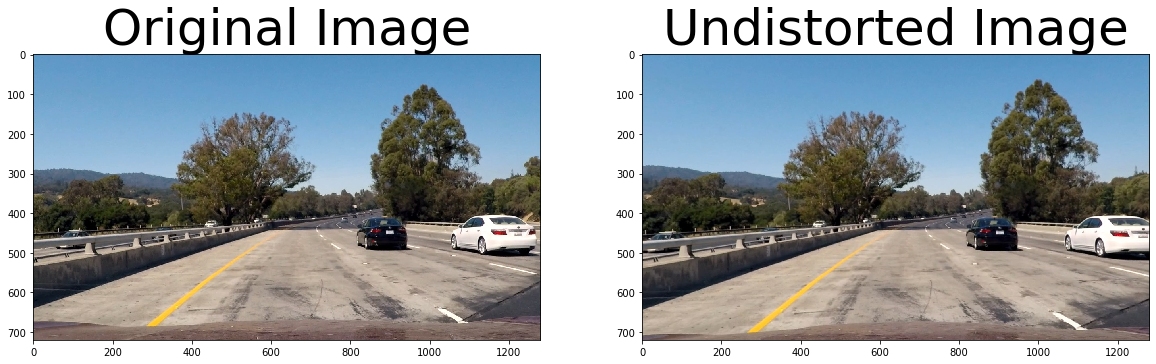

In [6]:
def undistort(img, objpoints, imgpoints):
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    #Undistorting a test image:
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

    
# Now let's test calibration on a real image
img = mpimg.imread('./test_images/test1.jpg')
dst = undistort(img, objpoints, imgpoints)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image', fontsize=50)
plt.imshow(dst)
plt.savefig('output_images/undistort_test1.png',dpi=100);

## Step 2: Use color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

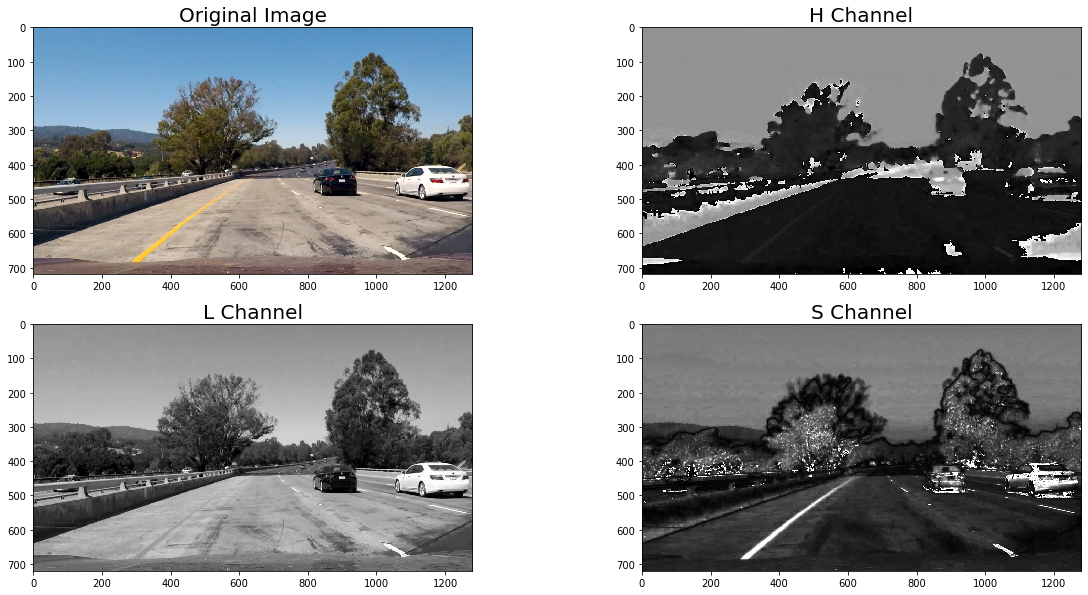

In [7]:
img = mpimg.imread('./test_images/test1.jpg')
fig=plt.figure(figsize=(20,10))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.subplot(2, 2, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
titles = ['H Channel','L Channel','S Channel']
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
for i in range(3):
    ch = hls[:,:,i]
    plt.subplot(2, 2, i+2)
    plt.title(titles[i], fontsize=20)
    plt.imshow(ch, cmap='gray')
    
plt.savefig('output_images/HLScolorchannels_test1.png',dpi=100);

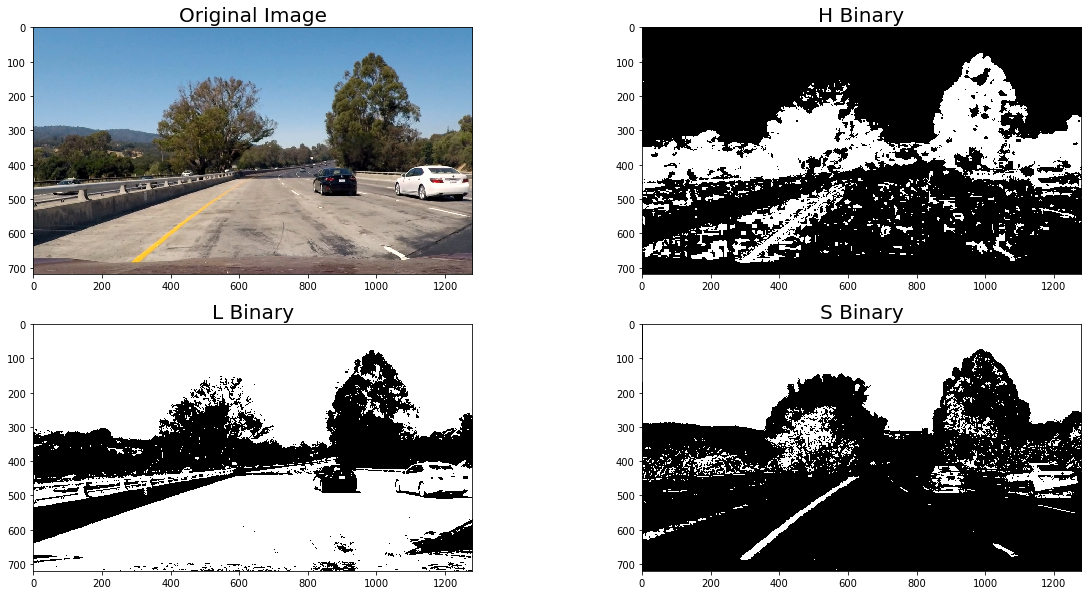

In [8]:
img = mpimg.imread('./test_images/test1.jpg')

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.subplot(2, 2, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
titles = ['H Binary','L Binary','S Binary']
thresh = [(15, 100),(90, 255),(90, 255)]
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
for i in range(3):
    ch = hls[:,:,i]
    binary = np.zeros_like(ch)
    binary[(ch > thresh[i][0]) & (ch <= thresh[i][1])] = 1
    plt.subplot(2, 2, i+2)
    plt.title(titles[i], fontsize=20)
    plt.imshow(binary, cmap='gray')
    
plt.savefig('output_images/HLScolorthresholds_test1.png',dpi=100);

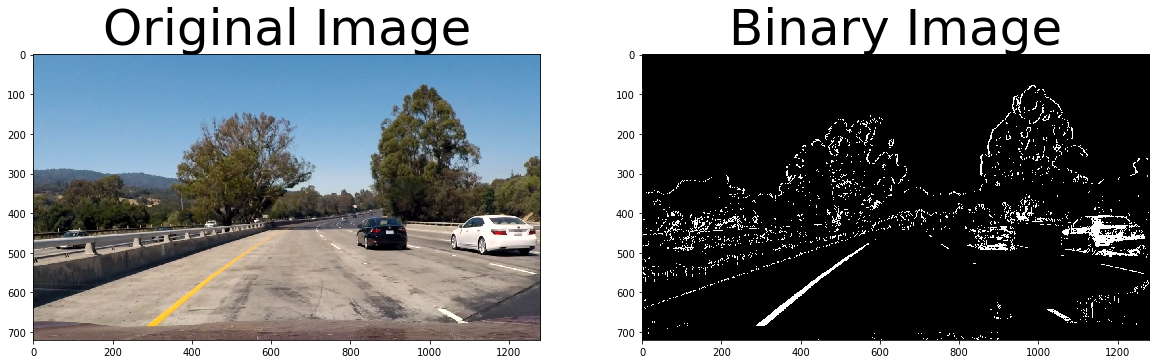

In [9]:
def createBinary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(h_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(sxbinary)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Now combine both
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Now let's test it on a real image
img = mpimg.imread('./test_images/test1.jpg')
dst = createBinary(img)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Binary Image', fontsize=50)
plt.imshow(dst, cmap='gray')
plt.savefig('output_images/binary_test1.png',dpi=100);

# Step 3: Perform a perspective transform and provide an example of a transformed image

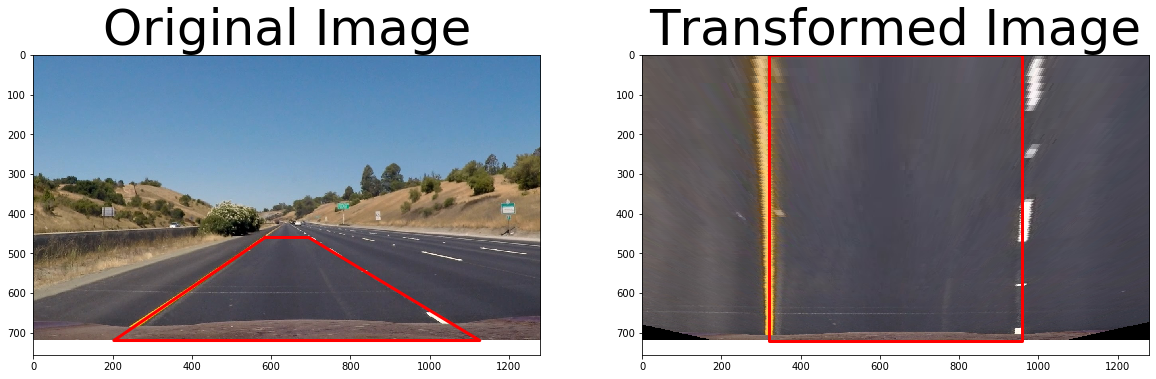

In [10]:
def warper(img):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped, src, dst, M, Minv

# Now let's test it on a real image
img = mpimg.imread('./test_images/straight_lines1.jpg')
warped, src, dst, M, Minv = warper(img)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.plot([i[0] for i in src]+[src[0][0]],[i[1] for i in src]+[src[0][1]], color='red',linewidth=3)
plt.subplot(1, 2, 2)
plt.title('Transformed Image', fontsize=50)
plt.imshow(warped, cmap='gray')
plt.plot([i[0] for i in dst]+[dst[0][0]],[i[1] for i in dst]+[dst[0][1]], color='red',linewidth=3)
plt.savefig('output_images/warp_test1.png',dpi=100);

## Step 4: Identify lane-line pixels and fit their positions with a polynomial

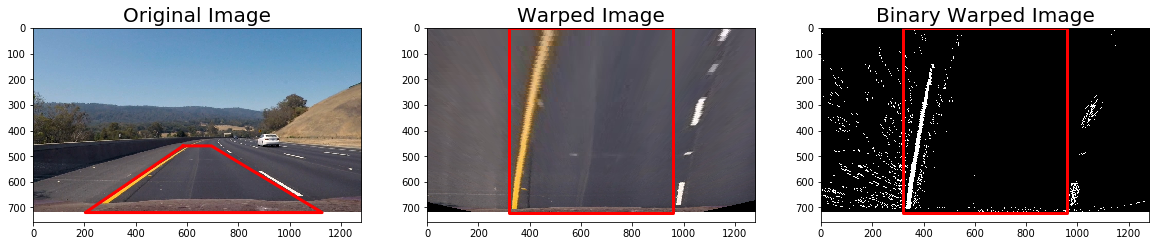

In [11]:
# Load our image
img = mpimg.imread('./test_images/test3.jpg')
warped, src, dst, M, Minv = warper(img)
binary_warped = createBinary(warped)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 3, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
plt.plot([i[0] for i in src]+[src[0][0]],[i[1] for i in src]+[src[0][1]], color='red',linewidth=3)
plt.subplot(1, 3, 2)
plt.title('Warped Image', fontsize=20)
plt.imshow(warped, cmap='gray')
plt.plot([i[0] for i in dst]+[dst[0][0]],[i[1] for i in dst]+[dst[0][1]], color='red',linewidth=3)
plt.subplot(1, 3, 3)
plt.title('Binary Warped Image', fontsize=20)
plt.imshow(binary_warped, cmap='gray')
plt.plot([i[0] for i in dst]+[dst[0][0]],[i[1] for i in dst]+[dst[0][1]], color='red',linewidth=3)

plt.savefig('output_images/binary_warped_test3.png',dpi=100);

slow


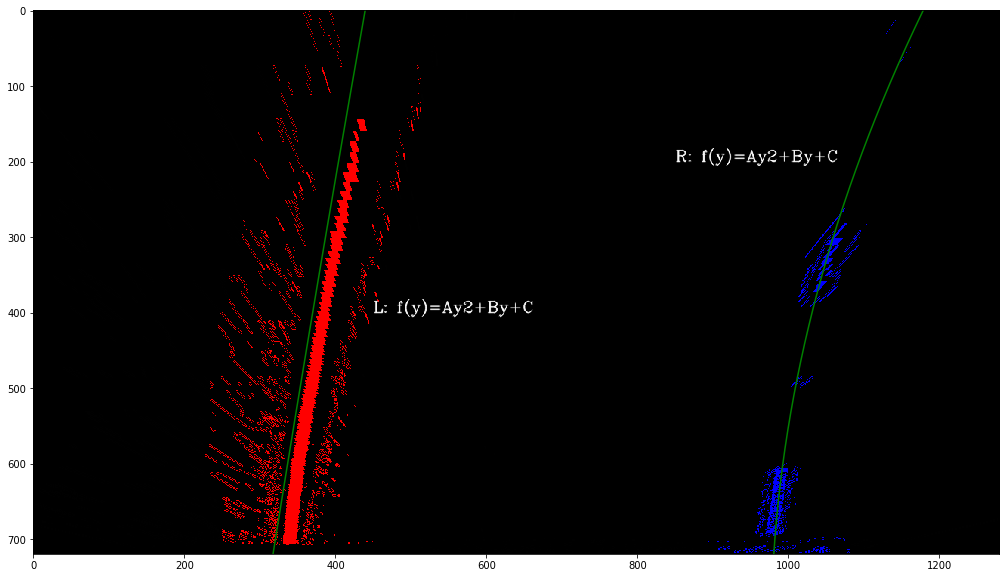

In [12]:
def use_windows(binary_warped,nonzerox,nonzeroy):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
#     # Identify the x and y positions of all nonzero pixels in the image
#     nonzero = binary_warped.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    return left_lane_inds, right_lane_inds

def search_around_poly(binary_warped,nonzerox,nonzeroy,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox >= left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]-margin) &  
                        (nonzerox < left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]+margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]-margin) &  
                        (nonzerox < right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]+margin)).nonzero()[0]
    return left_lane_inds, right_lane_inds


def find_lane_pixels(binary_warped):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if leftLine.detected:# and rightLine.detected:
        print('fast')
#         %timeit left_lane_inds, right_lane_inds = search_around_poly(binary_warped,nonzerox,nonzeroy,left_fit,right_fit)
        left_lane_inds, right_lane_inds = search_around_poly(binary_warped,nonzerox,nonzeroy,left_fit,right_fit)
    else:
        print('slow')
#         %timeit left_lane_inds, right_lane_inds = use_windows(binary_warped,nonzerox,nonzeroy)
        left_lane_inds, right_lane_inds = use_windows(binary_warped,nonzerox,nonzeroy)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx, lefty, leftx, righty, rightx

leftLine = Line()
rightLine = Line()
fig=plt.figure(figsize=(20,10))
fig.tight_layout()
ploty, left_fit, right_fit, left_fitx, right_fitx, lefty, leftx, righty, rightx = fit_polynomial(binary_warped)

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='green')

# textl = r'$f_\{right\}\(y\)=A_\{right\}y^2+B_\{right\}y+C_\{right\}$'
cv2.putText(out_img, 'L: f(y)=Ay2+By+C',
                (450,400),cv2.FONT_HERSHEY_COMPLEX,.7,(255,255,255),0,cv2.LINE_AA)
cv2.putText(out_img, 'R: f(y)=Ay2+By+C',
                (850,200),cv2.FONT_HERSHEY_COMPLEX,.7,(255,255,255),0,cv2.LINE_AA)

plt.imshow(out_img)
plt.savefig('output_images/fitted_test3.png',dpi=100);

# Step 5: Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

In [13]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, center_img):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    ##### Calculate the distance between center of image and center of lane
    left_x = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_x = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    center_x = (left_x + right_x)//2
    dist_m = xm_per_pix * (center_x - center_img)
    
    return left_curverad, right_curverad, np.round(dist_m,3)

ploty, left_fit, right_fit, left_fitx, right_fitx, lefty, leftx, righty, rightx = fit_polynomial(binary_warped)

left_curverad, right_curverad , dist_m = measure_curvature_real(ploty, left_fit, right_fit, out_img.shape[1]//2)

FinalText = "Radius of Curvature = "+str(min(int(left_curverad),int(right_curverad)))+'(m)\n'
if dist_m>0: FinalText+="vehicle is "+str(np.absolute(dist_m))+'m left of center'
elif dist_m <0: FinalText+="vehicle is "+str(np.absolute(dist_m))+'m right of center' 
else: FinalText+="vehicle is at the center"
print(FinalText)

slow
Radius of Curvature = 2311(m)
vehicle is 0.048m left of center


## Step 6: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [14]:
def getX(fit,y):
    return fit[0]*y**2 + fit[1]*y + fit[2]
print(getX(left_fit,np.max(ploty)),np.max(ploty))

317.4358827329962 719.0


In [15]:
def sanityCheck(left_curverad, right_curverad, left_fitx, right_fitx):
    if left_curverad > 500 and left_curverad < 3000: return True 
    if right_curverad > 500 and right_curverad < 3000: return True
    mid = left_fitx.shape[0]//2
    if np.absolute((left_fitx[-1] - right_fitx[-1]) - (left_fitx[mid] - right_fitx[mid]))< 700: return True
    return False


def updateLines(left_fit, right_fit, left_fitx, right_fitx, leftx, rightx, lefty, righty, left_curverad, right_curverad, xm_per_pix):
    n = 5
    fits = [left_fit, right_fit]
    fitxs = [left_fitx, right_fitx]
    lines = [leftLine, rightLine]
    Xs = [leftx, rightx]
    Ys = [lefty, righty]
    curve = [left_curverad, right_curverad]
    for i in range(2):
        lines[i].detected = True
        # x values of the last n fits of the line
        #average x values of the fitted line over the last n iterations
        if lines[i].recent_xfitted.size:
            lines[i].recent_xfitted = np.vstack((lines[i].recent_xfitted, fitxs[i]))
            lines[i].bestx = np.mean(lines[i].recent_xfitted[-n:,:],axis=0)
        else:
            lines[i].recent_xfitted = fitxs[i]
            lines[i].bestx = fitxs[i]
        # Polynomial coefficients of the last n fits of the line
        #polynomial coefficients averaged over the last n iterations
        if lines[i].recent_fit.size:
            lines[i].recent_fit = np.vstack((lines[i].recent_fit,fits[i])) 
            lines[i].best_fit = np.mean(lines[i].recent_fit[-n:,:],axis=0)
        else: 
            lines[i].recent_fit = fits[i]
            lines[i].best_fit = fits[i]
        #polynomial coefficients for the most recent fit
        lines[i].current_fit = [fits[i]]  
        #radius of curvature of the line in some units
        lines[i].radius_of_curvature = curve[i] 
        #distance in meters of vehicle center from the line
        lines[i].line_base_pos = xm_per_pix * np.absolute(350 - fitxs[i][-1]) 
        #difference in fit coefficients between last and new fits
        if len(lines[i].recent_fit) < 2: lines[i].diffs = 0
        else: lines[i].diffs = lines[i].recent_fit[-1] - lines[i].recent_fit[-2] 
        #x values for detected line pixels
        lines[i].allx = Xs[i]  
        #y values for detected line pixels
        lines[i].ally = Ys[i]
        # number of consequently failed checks in the last n rounds
        lines[i].failed = 0


slow


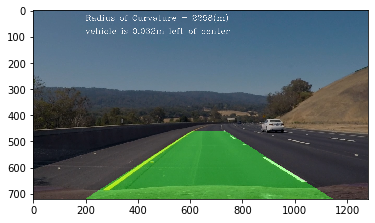

In [16]:
def pipeline(img, objpoints, imgpoints):
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    warped, src, dst, M, Minv = warper(undistorted)
    
    binary_warped = createBinary(warped)
    
    ploty, left_fit, right_fit, left_fitx, right_fitx, lefty, leftx, righty, rightx = fit_polynomial(binary_warped)
    
    left_curverad, right_curverad , dist_m = measure_curvature_real(ploty, left_fit, right_fit, out_img.shape[1]//2)
    
    xm_per_pix = 3.7/700
    if leftLine.detected:
        if sanityCheck(left_curverad, right_curverad, left_fitx, right_fitx):
            updateLines(left_fit, right_fit, left_fitx, right_fitx, leftx, rightx, lefty, righty, left_curverad, right_curverad, xm_per_pix)
        else:
            leftLine.failed = leftLine.failed + 1
            print('failed: ',leftLine.failed)
            if leftLine.failed > 5: 
                leftLine.detected = False
                leftLine.failed = 0
            left_curverad, right_curverad = leftLine.radius_of_curvature, rightLine.radius_of_curvature
    else:
        updateLines(left_fit, right_fit, left_fitx, right_fitx, leftx, rightx, lefty, righty, left_curverad, right_curverad, xm_per_pix)

    #print(leftLine.bestx, rightLine.bestx)    
    left_x, right_x = leftLine.bestx[-1], rightLine.bestx[-1]
    center_x = (left_x + right_x)//2
    dist_m = np.round(xm_per_pix * (center_x - out_img.shape[1]//2),3)
    left_fit, right_fit = leftLine.best_fit, rightLine.best_fit 

    #print(leftLine.bestx, rightLine.bestx)    
        
    ## Draw and fill the green polygon
    ### Calculate the unwarped counterpart of the two fits
    y_max = np.max(ploty)#src[1,1]
    y_min = np.min(ploty)#src[0,1]
    fitpoly = np.float32(
        [[getX(left_fit,y_max),y_max],
         [getX(left_fit,y_min),y_min],
         [getX(right_fit,y_min),y_min],
         [getX(right_fit,y_max),y_max]])
    
    polylay = np.zeros_like(warped)
    cv2.fillPoly(polylay, np.array([fitpoly], dtype=np.int32), (0,100,0),lineType=8, shift=0)
    #masked_warped = cv2.bitwise_and(warped, polylay)
    #warped = cv2.addWeighted(warped, 0.7, polylay, 1., 0.)
    unwarped_polylay = cv2.warpPerspective(polylay, Minv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_NEAREST)
    output_img = cv2.addWeighted(img, 0.7, unwarped_polylay, 1., 0.)
    
    
    FinalText1 = "Radius of Curvature = "+str(min(int(left_curverad),int(right_curverad)))+'(m)'
    if dist_m>0: FinalText2="vehicle is "+str(np.absolute(dist_m))+'m left of center'
    elif dist_m <0: FinalText2="vehicle is "+str(np.absolute(dist_m))+'m right of center' 
    else: FinalText2="vehicle is at the center"
    
    cv2.putText(output_img, FinalText1,(200,40),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),0,cv2.LINE_AA)
    cv2.putText(output_img, FinalText2,(200,90),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),0,cv2.LINE_AA)    
    return output_img#, FinalText

leftLine = Line()
rightLine = Line()
img = mpimg.imread('./test_images/test3.jpg')
output_img = pipeline(img, objpoints, imgpoints)
plt.imshow(output_img)
plt.savefig('output_images/pipeline_test3.png',dpi=100);

slow
fast
fast
fast
fast
fast
fast
fast


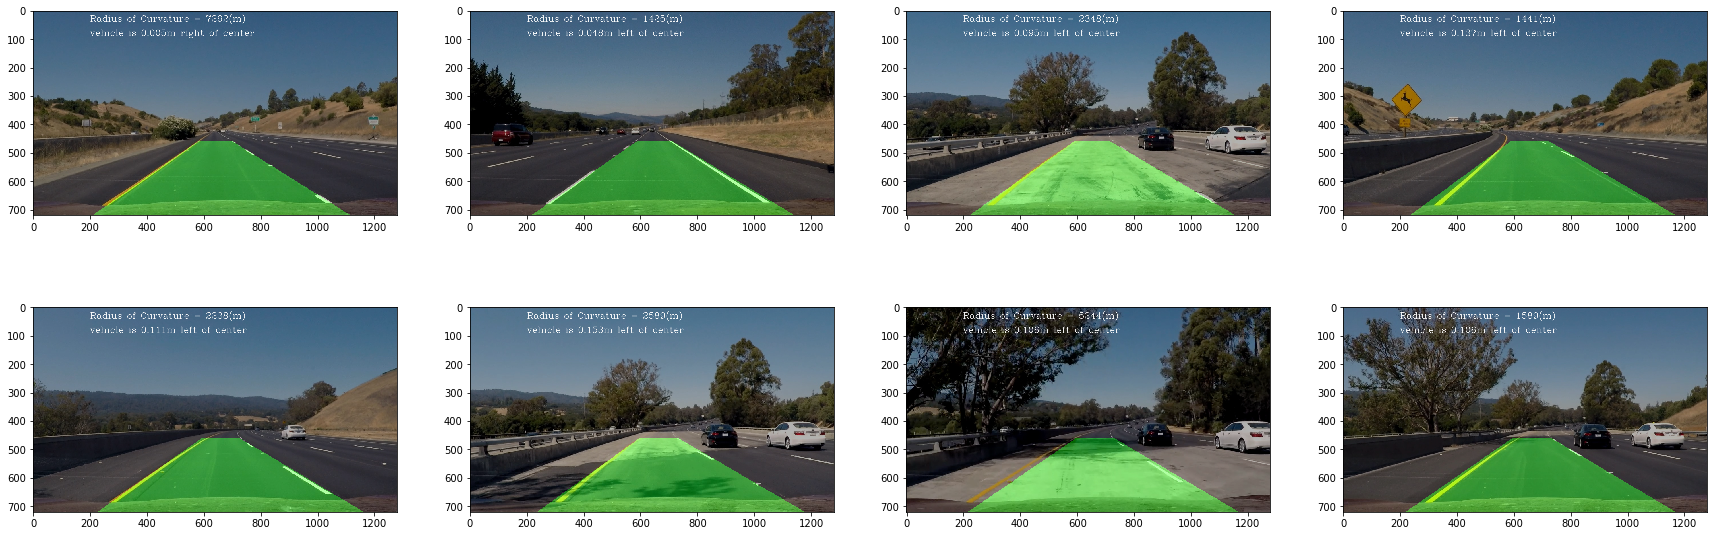

In [17]:
leftLine = Line()
rightLine = Line()
folder = './test_images/'
imgNames = os.listdir(folder)
fig=plt.figure(figsize=(30,10))
for i in range(len(imgNames)):
    plt.subplot(2, 4, i+1)
    image = mpimg.imread(folder+imgNames[i])
    output_img = pipeline(image, objpoints, imgpoints)
    plt.imshow(output_img)
    #plt.imsave('output_images/'+imgNames[i]+'_output.png', output_img)

## Step 7: Now test it on video.

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image, objpoints, imgpoints)
    return result

In [20]:
leftLine = Line()
rightLine = Line()
video_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")#.subclip(0,8)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

slow
Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



t:   0%|          | 2/1260 [00:00<07:38,  2.74it/s, now=None]

fast


t:   0%|          | 3/1260 [00:01<10:11,  2.06it/s, now=None]

fast


t:   0%|          | 4/1260 [00:02<12:24,  1.69it/s, now=None]

fast


t:   0%|          | 5/1260 [00:03<13:27,  1.55it/s, now=None]

fast


t:   0%|          | 6/1260 [00:03<14:43,  1.42it/s, now=None]

fast


t:   1%|          | 7/1260 [00:04<15:02,  1.39it/s, now=None]

fast


t:   1%|          | 8/1260 [00:05<15:08,  1.38it/s, now=None]

fast


t:   1%|          | 9/1260 [00:06<15:07,  1.38it/s, now=None]

fast


t:   1%|          | 10/1260 [00:06<15:12,  1.37it/s, now=None]

fast


t:   1%|          | 11/1260 [00:07<15:18,  1.36it/s, now=None]

fast


t:   1%|          | 12/1260 [00:08<15:13,  1.37it/s, now=None]

fast


t:   1%|          | 13/1260 [00:09<15:10,  1.37it/s, now=None]

fast


t:   1%|          | 14/1260 [00:09<15:25,  1.35it/s, now=None]

fast


t:   1%|          | 15/1260 [00:10<15:29,  1.34it/s, now=None]

fast


t:   1%|▏         | 16/1260 [00:11<15:21,  1.35it/s, now=None]

fast


t:   1%|▏         | 17/1260 [00:12<15:16,  1.36it/s, now=None]

fast


t:   1%|▏         | 18/1260 [00:12<15:20,  1.35it/s, now=None]

fast


t:   2%|▏         | 19/1260 [00:13<15:17,  1.35it/s, now=None]

fast


t:   2%|▏         | 20/1260 [00:14<15:16,  1.35it/s, now=None]

fast


t:   2%|▏         | 21/1260 [00:15<15:10,  1.36it/s, now=None]

fast


t:   2%|▏         | 22/1260 [00:15<15:07,  1.36it/s, now=None]

fast


t:   2%|▏         | 23/1260 [00:16<15:11,  1.36it/s, now=None]

fast


t:   2%|▏         | 24/1260 [00:17<15:10,  1.36it/s, now=None]

fast


t:   2%|▏         | 25/1260 [00:17<15:07,  1.36it/s, now=None]

fast


t:   2%|▏         | 26/1260 [00:18<15:08,  1.36it/s, now=None]

fast


t:   2%|▏         | 27/1260 [00:19<15:57,  1.29it/s, now=None]

fast


t:   2%|▏         | 28/1260 [00:20<15:36,  1.32it/s, now=None]

fast


t:   2%|▏         | 29/1260 [00:21<15:42,  1.31it/s, now=None]

fast


t:   2%|▏         | 30/1260 [00:21<15:52,  1.29it/s, now=None]

fast


t:   2%|▏         | 31/1260 [00:22<15:43,  1.30it/s, now=None]

fast


t:   3%|▎         | 32/1260 [00:23<15:39,  1.31it/s, now=None]

fast


t:   3%|▎         | 33/1260 [00:24<15:37,  1.31it/s, now=None]

fast


t:   3%|▎         | 34/1260 [00:24<15:35,  1.31it/s, now=None]

fast


t:   3%|▎         | 35/1260 [00:25<16:21,  1.25it/s, now=None]

fast


t:   3%|▎         | 36/1260 [00:26<15:46,  1.29it/s, now=None]

fast


t:   3%|▎         | 37/1260 [00:27<16:37,  1.23it/s, now=None]

fast


t:   3%|▎         | 38/1260 [00:28<16:01,  1.27it/s, now=None]

fast


t:   3%|▎         | 39/1260 [00:28<16:18,  1.25it/s, now=None]

fast


t:   3%|▎         | 40/1260 [00:29<16:47,  1.21it/s, now=None]

fast


t:   3%|▎         | 41/1260 [00:30<17:00,  1.19it/s, now=None]

fast


t:   3%|▎         | 42/1260 [00:31<16:39,  1.22it/s, now=None]

fast


t:   3%|▎         | 43/1260 [00:32<16:20,  1.24it/s, now=None]

fast


t:   3%|▎         | 44/1260 [00:33<16:34,  1.22it/s, now=None]

fast


t:   4%|▎         | 45/1260 [00:33<16:30,  1.23it/s, now=None]

fast


t:   4%|▎         | 46/1260 [00:34<17:28,  1.16it/s, now=None]

fast


t:   4%|▎         | 47/1260 [00:35<16:58,  1.19it/s, now=None]

fast


t:   4%|▍         | 48/1260 [00:36<16:46,  1.20it/s, now=None]

fast


t:   4%|▍         | 49/1260 [00:37<17:24,  1.16it/s, now=None]

fast


t:   4%|▍         | 50/1260 [00:38<17:31,  1.15it/s, now=None]

fast


t:   4%|▍         | 51/1260 [00:39<16:53,  1.19it/s, now=None]

fast


t:   4%|▍         | 52/1260 [00:39<16:48,  1.20it/s, now=None]

fast


t:   4%|▍         | 53/1260 [00:40<16:25,  1.23it/s, now=None]

fast


t:   4%|▍         | 54/1260 [00:41<16:37,  1.21it/s, now=None]

fast


t:   4%|▍         | 55/1260 [00:42<16:05,  1.25it/s, now=None]

fast


t:   4%|▍         | 56/1260 [00:43<15:53,  1.26it/s, now=None]

fast


t:   5%|▍         | 57/1260 [00:43<15:49,  1.27it/s, now=None]

fast


t:   5%|▍         | 58/1260 [00:44<15:39,  1.28it/s, now=None]

fast


t:   5%|▍         | 59/1260 [00:45<15:56,  1.26it/s, now=None]

fast


t:   5%|▍         | 60/1260 [00:46<15:38,  1.28it/s, now=None]

fast


t:   5%|▍         | 61/1260 [00:46<15:26,  1.29it/s, now=None]

fast


t:   5%|▍         | 62/1260 [00:47<15:20,  1.30it/s, now=None]

fast


t:   5%|▌         | 63/1260 [00:48<15:15,  1.31it/s, now=None]

fast


t:   5%|▌         | 64/1260 [00:49<15:52,  1.26it/s, now=None]

fast


t:   5%|▌         | 65/1260 [00:50<15:27,  1.29it/s, now=None]

fast


t:   5%|▌         | 66/1260 [00:50<15:12,  1.31it/s, now=None]

fast


t:   5%|▌         | 67/1260 [00:51<15:15,  1.30it/s, now=None]

fast


t:   5%|▌         | 68/1260 [00:52<15:20,  1.30it/s, now=None]

fast


t:   5%|▌         | 69/1260 [00:53<15:33,  1.28it/s, now=None]

fast


t:   6%|▌         | 70/1260 [00:53<15:38,  1.27it/s, now=None]

fast


t:   6%|▌         | 71/1260 [00:54<15:45,  1.26it/s, now=None]

fast


t:   6%|▌         | 72/1260 [00:55<15:52,  1.25it/s, now=None]

fast


t:   6%|▌         | 73/1260 [00:56<15:43,  1.26it/s, now=None]

fast


t:   6%|▌         | 74/1260 [00:57<16:06,  1.23it/s, now=None]

fast


t:   6%|▌         | 75/1260 [00:58<16:19,  1.21it/s, now=None]

fast


t:   6%|▌         | 76/1260 [00:58<16:19,  1.21it/s, now=None]

fast


t:   6%|▌         | 77/1260 [00:59<15:53,  1.24it/s, now=None]

fast


t:   6%|▌         | 78/1260 [01:00<16:21,  1.20it/s, now=None]

fast


t:   6%|▋         | 79/1260 [01:01<16:16,  1.21it/s, now=None]

fast


t:   6%|▋         | 80/1260 [01:02<15:50,  1.24it/s, now=None]

fast


t:   6%|▋         | 81/1260 [01:02<15:46,  1.25it/s, now=None]

fast


t:   7%|▋         | 82/1260 [01:03<16:23,  1.20it/s, now=None]

fast


t:   7%|▋         | 83/1260 [01:04<16:07,  1.22it/s, now=None]

fast


t:   7%|▋         | 84/1260 [01:05<16:07,  1.22it/s, now=None]

fast


t:   7%|▋         | 85/1260 [01:06<16:01,  1.22it/s, now=None]

fast


t:   7%|▋         | 86/1260 [01:07<15:43,  1.24it/s, now=None]

fast


t:   7%|▋         | 87/1260 [01:07<15:50,  1.23it/s, now=None]

fast


t:   7%|▋         | 88/1260 [01:08<15:31,  1.26it/s, now=None]

fast


t:   7%|▋         | 89/1260 [01:09<15:21,  1.27it/s, now=None]

fast


t:   7%|▋         | 90/1260 [01:10<15:12,  1.28it/s, now=None]

fast


t:   7%|▋         | 91/1260 [01:10<15:04,  1.29it/s, now=None]

fast


t:   7%|▋         | 92/1260 [01:11<14:53,  1.31it/s, now=None]

fast


t:   7%|▋         | 93/1260 [01:12<15:15,  1.27it/s, now=None]

fast


t:   7%|▋         | 94/1260 [01:13<15:18,  1.27it/s, now=None]

fast


t:   8%|▊         | 95/1260 [01:14<15:09,  1.28it/s, now=None]

fast


t:   8%|▊         | 96/1260 [01:14<15:42,  1.23it/s, now=None]

fast


t:   8%|▊         | 97/1260 [01:15<15:18,  1.27it/s, now=None]

fast


t:   8%|▊         | 98/1260 [01:16<15:41,  1.23it/s, now=None]

fast


t:   8%|▊         | 99/1260 [01:17<15:21,  1.26it/s, now=None]

fast


t:   8%|▊         | 100/1260 [01:18<15:03,  1.28it/s, now=None]

fast


t:   8%|▊         | 101/1260 [01:18<14:52,  1.30it/s, now=None]

fast


t:   8%|▊         | 102/1260 [01:19<15:31,  1.24it/s, now=None]

fast


t:   8%|▊         | 103/1260 [01:20<15:10,  1.27it/s, now=None]

fast


t:   8%|▊         | 104/1260 [01:21<15:01,  1.28it/s, now=None]

fast


t:   8%|▊         | 105/1260 [01:21<15:12,  1.27it/s, now=None]

fast


t:   8%|▊         | 106/1260 [01:22<15:08,  1.27it/s, now=None]

fast


t:   8%|▊         | 107/1260 [01:23<15:34,  1.23it/s, now=None]

fast


t:   9%|▊         | 108/1260 [01:24<15:14,  1.26it/s, now=None]

fast


t:   9%|▊         | 109/1260 [01:25<14:51,  1.29it/s, now=None]

fast


t:   9%|▊         | 110/1260 [01:25<14:38,  1.31it/s, now=None]

fast


t:   9%|▉         | 111/1260 [01:26<14:23,  1.33it/s, now=None]

fast


t:   9%|▉         | 112/1260 [01:27<14:14,  1.34it/s, now=None]

fast


t:   9%|▉         | 113/1260 [01:28<14:10,  1.35it/s, now=None]

fast


t:   9%|▉         | 114/1260 [01:28<14:25,  1.32it/s, now=None]

fast


t:   9%|▉         | 115/1260 [01:29<14:16,  1.34it/s, now=None]

fast


t:   9%|▉         | 116/1260 [01:30<14:04,  1.35it/s, now=None]

fast


t:   9%|▉         | 117/1260 [01:31<14:07,  1.35it/s, now=None]

fast


t:   9%|▉         | 118/1260 [01:31<14:06,  1.35it/s, now=None]

fast


t:   9%|▉         | 119/1260 [01:32<14:04,  1.35it/s, now=None]

fast


t:  10%|▉         | 120/1260 [01:33<13:58,  1.36it/s, now=None]

fast


t:  10%|▉         | 121/1260 [01:33<13:52,  1.37it/s, now=None]

fast


t:  10%|▉         | 122/1260 [01:34<14:00,  1.35it/s, now=None]

fast


t:  10%|▉         | 123/1260 [01:35<14:00,  1.35it/s, now=None]

fast


t:  10%|▉         | 124/1260 [01:36<14:01,  1.35it/s, now=None]

fast


t:  10%|▉         | 125/1260 [01:36<13:55,  1.36it/s, now=None]

fast


t:  10%|█         | 126/1260 [01:37<14:13,  1.33it/s, now=None]

fast


t:  10%|█         | 127/1260 [01:38<14:08,  1.33it/s, now=None]

fast


t:  10%|█         | 128/1260 [01:39<14:12,  1.33it/s, now=None]

fast


t:  10%|█         | 129/1260 [01:40<14:37,  1.29it/s, now=None]

fast


t:  10%|█         | 130/1260 [01:40<14:41,  1.28it/s, now=None]

fast


t:  10%|█         | 131/1260 [01:41<14:39,  1.28it/s, now=None]

fast


t:  10%|█         | 132/1260 [01:42<14:30,  1.30it/s, now=None]

fast


t:  11%|█         | 133/1260 [01:43<14:23,  1.31it/s, now=None]

fast


t:  11%|█         | 134/1260 [01:43<14:31,  1.29it/s, now=None]

fast


t:  11%|█         | 135/1260 [01:44<14:17,  1.31it/s, now=None]

fast


t:  11%|█         | 136/1260 [01:45<14:14,  1.32it/s, now=None]

fast


t:  11%|█         | 137/1260 [01:46<14:12,  1.32it/s, now=None]

fast


t:  11%|█         | 138/1260 [01:46<14:04,  1.33it/s, now=None]

fast


t:  11%|█         | 139/1260 [01:47<13:59,  1.34it/s, now=None]

fast


t:  11%|█         | 140/1260 [01:48<14:14,  1.31it/s, now=None]

fast


t:  11%|█         | 141/1260 [01:49<14:04,  1.33it/s, now=None]

fast


t:  11%|█▏        | 142/1260 [01:49<14:01,  1.33it/s, now=None]

fast


t:  11%|█▏        | 143/1260 [01:50<13:57,  1.33it/s, now=None]

fast


t:  11%|█▏        | 144/1260 [01:51<13:47,  1.35it/s, now=None]

fast


t:  12%|█▏        | 145/1260 [01:52<13:40,  1.36it/s, now=None]

fast


t:  12%|█▏        | 146/1260 [01:52<13:47,  1.35it/s, now=None]

fast


t:  12%|█▏        | 147/1260 [01:53<14:01,  1.32it/s, now=None]

fast


t:  12%|█▏        | 148/1260 [01:54<13:52,  1.34it/s, now=None]

fast


t:  12%|█▏        | 149/1260 [01:55<13:56,  1.33it/s, now=None]

fast


t:  12%|█▏        | 150/1260 [01:55<13:49,  1.34it/s, now=None]

fast


t:  12%|█▏        | 151/1260 [01:56<14:23,  1.28it/s, now=None]

fast


t:  12%|█▏        | 152/1260 [01:57<14:38,  1.26it/s, now=None]

fast


t:  12%|█▏        | 153/1260 [01:58<14:27,  1.28it/s, now=None]

fast


t:  12%|█▏        | 154/1260 [01:59<14:35,  1.26it/s, now=None]

fast


t:  12%|█▏        | 155/1260 [01:59<14:29,  1.27it/s, now=None]

fast


t:  12%|█▏        | 156/1260 [02:00<15:05,  1.22it/s, now=None]

fast


t:  12%|█▏        | 157/1260 [02:01<14:36,  1.26it/s, now=None]

fast


t:  13%|█▎        | 158/1260 [02:02<14:14,  1.29it/s, now=None]

fast


t:  13%|█▎        | 159/1260 [02:02<13:56,  1.32it/s, now=None]

fast


t:  13%|█▎        | 160/1260 [02:03<13:47,  1.33it/s, now=None]

fast


t:  13%|█▎        | 161/1260 [02:04<13:49,  1.33it/s, now=None]

fast


t:  13%|█▎        | 162/1260 [02:05<13:52,  1.32it/s, now=None]

fast


t:  13%|█▎        | 163/1260 [02:05<13:44,  1.33it/s, now=None]

fast


t:  13%|█▎        | 164/1260 [02:06<14:19,  1.28it/s, now=None]

fast


t:  13%|█▎        | 165/1260 [02:07<13:59,  1.30it/s, now=None]

fast


t:  13%|█▎        | 166/1260 [02:08<13:57,  1.31it/s, now=None]

fast


t:  13%|█▎        | 167/1260 [02:09<13:45,  1.32it/s, now=None]

fast


t:  13%|█▎        | 168/1260 [02:09<13:40,  1.33it/s, now=None]

fast


t:  13%|█▎        | 169/1260 [02:10<13:31,  1.34it/s, now=None]

fast


t:  13%|█▎        | 170/1260 [02:11<13:24,  1.36it/s, now=None]

fast


t:  14%|█▎        | 171/1260 [02:11<13:26,  1.35it/s, now=None]

fast


t:  14%|█▎        | 172/1260 [02:12<13:23,  1.35it/s, now=None]

fast


t:  14%|█▎        | 173/1260 [02:13<13:26,  1.35it/s, now=None]

fast


t:  14%|█▍        | 174/1260 [02:14<13:23,  1.35it/s, now=None]

fast


t:  14%|█▍        | 175/1260 [02:14<13:18,  1.36it/s, now=None]

fast


t:  14%|█▍        | 176/1260 [02:15<13:45,  1.31it/s, now=None]

fast


t:  14%|█▍        | 177/1260 [02:16<14:12,  1.27it/s, now=None]

fast


t:  14%|█▍        | 178/1260 [02:17<13:59,  1.29it/s, now=None]

fast


t:  14%|█▍        | 179/1260 [02:18<13:41,  1.32it/s, now=None]

fast


t:  14%|█▍        | 180/1260 [02:18<13:39,  1.32it/s, now=None]

fast


t:  14%|█▍        | 181/1260 [02:19<13:32,  1.33it/s, now=None]

fast


t:  14%|█▍        | 182/1260 [02:20<13:29,  1.33it/s, now=None]

fast


t:  15%|█▍        | 183/1260 [02:21<13:27,  1.33it/s, now=None]

fast


t:  15%|█▍        | 184/1260 [02:21<13:15,  1.35it/s, now=None]

fast


t:  15%|█▍        | 185/1260 [02:22<13:15,  1.35it/s, now=None]

fast


t:  15%|█▍        | 186/1260 [02:23<13:09,  1.36it/s, now=None]

fast


t:  15%|█▍        | 187/1260 [02:23<13:08,  1.36it/s, now=None]

fast


t:  15%|█▍        | 188/1260 [02:24<13:14,  1.35it/s, now=None]

fast


t:  15%|█▌        | 189/1260 [02:25<13:53,  1.29it/s, now=None]

fast


t:  15%|█▌        | 190/1260 [02:26<13:37,  1.31it/s, now=None]

fast


t:  15%|█▌        | 191/1260 [02:27<13:33,  1.31it/s, now=None]

fast


t:  15%|█▌        | 192/1260 [02:27<13:21,  1.33it/s, now=None]

fast


t:  15%|█▌        | 193/1260 [02:28<13:36,  1.31it/s, now=None]

fast


t:  15%|█▌        | 194/1260 [02:29<13:49,  1.28it/s, now=None]

fast


t:  15%|█▌        | 195/1260 [02:30<13:35,  1.31it/s, now=None]

fast


t:  16%|█▌        | 196/1260 [02:30<13:34,  1.31it/s, now=None]

fast


t:  16%|█▌        | 197/1260 [02:31<14:03,  1.26it/s, now=None]

fast


t:  16%|█▌        | 198/1260 [02:32<13:44,  1.29it/s, now=None]

fast


t:  16%|█▌        | 199/1260 [02:33<13:46,  1.28it/s, now=None]

fast


t:  16%|█▌        | 200/1260 [02:34<13:28,  1.31it/s, now=None]

fast


t:  16%|█▌        | 201/1260 [02:34<13:18,  1.33it/s, now=None]

fast


t:  16%|█▌        | 202/1260 [02:35<13:15,  1.33it/s, now=None]

fast


t:  16%|█▌        | 203/1260 [02:36<13:05,  1.34it/s, now=None]

fast


t:  16%|█▌        | 204/1260 [02:37<14:00,  1.26it/s, now=None]

fast


t:  16%|█▋        | 205/1260 [02:37<13:54,  1.26it/s, now=None]

fast


t:  16%|█▋        | 206/1260 [02:38<13:44,  1.28it/s, now=None]

fast


t:  16%|█▋        | 207/1260 [02:39<13:22,  1.31it/s, now=None]

fast


t:  17%|█▋        | 208/1260 [02:40<13:10,  1.33it/s, now=None]

fast


t:  17%|█▋        | 209/1260 [02:40<12:58,  1.35it/s, now=None]

fast


t:  17%|█▋        | 210/1260 [02:41<13:05,  1.34it/s, now=None]

fast


t:  17%|█▋        | 211/1260 [02:42<13:02,  1.34it/s, now=None]

fast


t:  17%|█▋        | 212/1260 [02:43<12:57,  1.35it/s, now=None]

fast


t:  17%|█▋        | 213/1260 [02:43<13:39,  1.28it/s, now=None]

fast


t:  17%|█▋        | 214/1260 [02:44<13:35,  1.28it/s, now=None]

fast


t:  17%|█▋        | 215/1260 [02:45<13:37,  1.28it/s, now=None]

fast


t:  17%|█▋        | 216/1260 [02:46<13:30,  1.29it/s, now=None]

fast


t:  17%|█▋        | 217/1260 [02:46<13:12,  1.32it/s, now=None]

fast


t:  17%|█▋        | 218/1260 [02:47<13:05,  1.33it/s, now=None]

fast


t:  17%|█▋        | 219/1260 [02:48<12:57,  1.34it/s, now=None]

fast


t:  17%|█▋        | 220/1260 [02:49<12:49,  1.35it/s, now=None]

fast


t:  18%|█▊        | 221/1260 [02:49<13:02,  1.33it/s, now=None]

fast


t:  18%|█▊        | 222/1260 [02:50<13:05,  1.32it/s, now=None]

fast


t:  18%|█▊        | 223/1260 [02:51<13:34,  1.27it/s, now=None]

fast


t:  18%|█▊        | 224/1260 [02:52<13:14,  1.30it/s, now=None]

fast


t:  18%|█▊        | 225/1260 [02:53<12:55,  1.33it/s, now=None]

fast


t:  18%|█▊        | 226/1260 [02:53<12:48,  1.35it/s, now=None]

fast


t:  18%|█▊        | 227/1260 [02:54<12:37,  1.36it/s, now=None]

fast


t:  18%|█▊        | 228/1260 [02:55<12:34,  1.37it/s, now=None]

fast


t:  18%|█▊        | 229/1260 [02:55<12:29,  1.38it/s, now=None]

fast


t:  18%|█▊        | 230/1260 [02:56<12:23,  1.39it/s, now=None]

fast


t:  18%|█▊        | 231/1260 [02:57<12:21,  1.39it/s, now=None]

fast


t:  18%|█▊        | 232/1260 [02:58<12:17,  1.39it/s, now=None]

fast


t:  18%|█▊        | 233/1260 [02:58<12:16,  1.39it/s, now=None]

fast


t:  19%|█▊        | 234/1260 [02:59<12:27,  1.37it/s, now=None]

fast


t:  19%|█▊        | 235/1260 [03:00<12:25,  1.38it/s, now=None]

fast


t:  19%|█▊        | 236/1260 [03:00<12:22,  1.38it/s, now=None]

fast


t:  19%|█▉        | 237/1260 [03:01<12:25,  1.37it/s, now=None]

fast


t:  19%|█▉        | 238/1260 [03:02<12:29,  1.36it/s, now=None]

fast


t:  19%|█▉        | 239/1260 [03:03<12:28,  1.36it/s, now=None]

fast


t:  19%|█▉        | 240/1260 [03:03<12:26,  1.37it/s, now=None]

fast


t:  19%|█▉        | 241/1260 [03:04<12:20,  1.38it/s, now=None]

fast


t:  19%|█▉        | 242/1260 [03:05<12:22,  1.37it/s, now=None]

fast


t:  19%|█▉        | 243/1260 [03:06<12:44,  1.33it/s, now=None]

fast


t:  19%|█▉        | 244/1260 [03:06<12:34,  1.35it/s, now=None]

fast


t:  19%|█▉        | 245/1260 [03:07<12:27,  1.36it/s, now=None]

fast


t:  20%|█▉        | 246/1260 [03:08<12:28,  1.35it/s, now=None]

fast


t:  20%|█▉        | 247/1260 [03:09<12:36,  1.34it/s, now=None]

fast


t:  20%|█▉        | 248/1260 [03:09<12:21,  1.37it/s, now=None]

fast


t:  20%|█▉        | 249/1260 [03:10<12:23,  1.36it/s, now=None]

fast


t:  20%|█▉        | 250/1260 [03:11<12:22,  1.36it/s, now=None]

fast


t:  20%|█▉        | 251/1260 [03:12<12:22,  1.36it/s, now=None]

fast


t:  20%|██        | 252/1260 [03:12<12:17,  1.37it/s, now=None]

fast


t:  20%|██        | 253/1260 [03:13<12:14,  1.37it/s, now=None]

fast


t:  20%|██        | 254/1260 [03:14<12:15,  1.37it/s, now=None]

fast


t:  20%|██        | 255/1260 [03:14<12:09,  1.38it/s, now=None]

fast


t:  20%|██        | 256/1260 [03:15<12:14,  1.37it/s, now=None]

fast


t:  20%|██        | 257/1260 [03:16<12:24,  1.35it/s, now=None]

fast


t:  20%|██        | 258/1260 [03:17<12:22,  1.35it/s, now=None]

fast


t:  21%|██        | 259/1260 [03:17<12:13,  1.37it/s, now=None]

fast


t:  21%|██        | 260/1260 [03:18<12:18,  1.35it/s, now=None]

fast


t:  21%|██        | 261/1260 [03:19<12:14,  1.36it/s, now=None]

fast


t:  21%|██        | 262/1260 [03:20<12:08,  1.37it/s, now=None]

fast


t:  21%|██        | 263/1260 [03:20<12:08,  1.37it/s, now=None]

fast


t:  21%|██        | 264/1260 [03:21<12:07,  1.37it/s, now=None]

fast


t:  21%|██        | 265/1260 [03:22<12:06,  1.37it/s, now=None]

fast


t:  21%|██        | 266/1260 [03:22<12:03,  1.37it/s, now=None]

fast


t:  21%|██        | 267/1260 [03:23<12:12,  1.36it/s, now=None]

fast


t:  21%|██▏       | 268/1260 [03:24<12:14,  1.35it/s, now=None]

fast


t:  21%|██▏       | 269/1260 [03:25<12:12,  1.35it/s, now=None]

fast


t:  21%|██▏       | 270/1260 [03:25<12:04,  1.37it/s, now=None]

fast


t:  22%|██▏       | 271/1260 [03:26<11:57,  1.38it/s, now=None]

fast


t:  22%|██▏       | 272/1260 [03:27<11:53,  1.38it/s, now=None]

fast


t:  22%|██▏       | 273/1260 [03:28<11:50,  1.39it/s, now=None]

fast


t:  22%|██▏       | 274/1260 [03:28<11:55,  1.38it/s, now=None]

fast


t:  22%|██▏       | 275/1260 [03:29<12:21,  1.33it/s, now=None]

fast


t:  22%|██▏       | 276/1260 [03:30<12:09,  1.35it/s, now=None]

fast


t:  22%|██▏       | 277/1260 [03:31<11:59,  1.37it/s, now=None]

fast


t:  22%|██▏       | 278/1260 [03:31<12:20,  1.33it/s, now=None]

fast


t:  22%|██▏       | 279/1260 [03:32<12:08,  1.35it/s, now=None]

fast


t:  22%|██▏       | 280/1260 [03:33<12:01,  1.36it/s, now=None]

fast


t:  22%|██▏       | 281/1260 [03:34<11:58,  1.36it/s, now=None]

fast


t:  22%|██▏       | 282/1260 [03:34<11:54,  1.37it/s, now=None]

fast


t:  22%|██▏       | 283/1260 [03:35<11:54,  1.37it/s, now=None]

fast


t:  23%|██▎       | 284/1260 [03:36<11:47,  1.38it/s, now=None]

fast


t:  23%|██▎       | 285/1260 [03:36<11:44,  1.38it/s, now=None]

fast


t:  23%|██▎       | 286/1260 [03:37<11:46,  1.38it/s, now=None]

fast


t:  23%|██▎       | 287/1260 [03:38<11:46,  1.38it/s, now=None]

fast


t:  23%|██▎       | 288/1260 [03:39<11:47,  1.37it/s, now=None]

fast


t:  23%|██▎       | 289/1260 [03:39<11:43,  1.38it/s, now=None]

fast


t:  23%|██▎       | 290/1260 [03:40<11:50,  1.37it/s, now=None]

fast


t:  23%|██▎       | 291/1260 [03:41<11:56,  1.35it/s, now=None]

fast


t:  23%|██▎       | 292/1260 [03:42<11:52,  1.36it/s, now=None]

fast


t:  23%|██▎       | 293/1260 [03:42<11:48,  1.37it/s, now=None]

fast


t:  23%|██▎       | 294/1260 [03:43<11:54,  1.35it/s, now=None]

fast


t:  23%|██▎       | 295/1260 [03:44<11:46,  1.37it/s, now=None]

fast


t:  23%|██▎       | 296/1260 [03:44<11:39,  1.38it/s, now=None]

fast


t:  24%|██▎       | 297/1260 [03:45<11:36,  1.38it/s, now=None]

fast


t:  24%|██▎       | 298/1260 [03:46<12:05,  1.33it/s, now=None]

fast


t:  24%|██▎       | 299/1260 [03:47<11:58,  1.34it/s, now=None]

fast


t:  24%|██▍       | 300/1260 [03:47<11:45,  1.36it/s, now=None]

fast


t:  24%|██▍       | 301/1260 [03:48<11:41,  1.37it/s, now=None]

fast


t:  24%|██▍       | 302/1260 [03:49<11:38,  1.37it/s, now=None]

fast


t:  24%|██▍       | 303/1260 [03:50<11:36,  1.37it/s, now=None]

fast


t:  24%|██▍       | 304/1260 [03:50<11:40,  1.36it/s, now=None]

fast


t:  24%|██▍       | 305/1260 [03:51<11:45,  1.35it/s, now=None]

fast


t:  24%|██▍       | 306/1260 [03:52<11:43,  1.36it/s, now=None]

fast


t:  24%|██▍       | 307/1260 [03:53<11:41,  1.36it/s, now=None]

fast


t:  24%|██▍       | 308/1260 [03:53<11:42,  1.36it/s, now=None]

fast


t:  25%|██▍       | 309/1260 [03:54<11:37,  1.36it/s, now=None]

fast


t:  25%|██▍       | 310/1260 [03:55<11:38,  1.36it/s, now=None]

fast


t:  25%|██▍       | 311/1260 [03:56<11:35,  1.36it/s, now=None]

fast


t:  25%|██▍       | 312/1260 [03:56<12:10,  1.30it/s, now=None]

fast


t:  25%|██▍       | 313/1260 [03:57<12:24,  1.27it/s, now=None]

fast


t:  25%|██▍       | 314/1260 [03:58<12:00,  1.31it/s, now=None]

fast


t:  25%|██▌       | 315/1260 [03:59<12:23,  1.27it/s, now=None]

fast


t:  25%|██▌       | 316/1260 [03:59<12:02,  1.31it/s, now=None]

fast


t:  25%|██▌       | 317/1260 [04:00<11:45,  1.34it/s, now=None]

fast


t:  25%|██▌       | 318/1260 [04:01<11:42,  1.34it/s, now=None]

fast


t:  25%|██▌       | 319/1260 [04:02<11:36,  1.35it/s, now=None]

fast


t:  25%|██▌       | 320/1260 [04:02<11:32,  1.36it/s, now=None]

fast


t:  25%|██▌       | 321/1260 [04:03<11:33,  1.35it/s, now=None]

fast


t:  26%|██▌       | 322/1260 [04:04<11:32,  1.35it/s, now=None]

fast


t:  26%|██▌       | 323/1260 [04:05<11:27,  1.36it/s, now=None]

fast


t:  26%|██▌       | 324/1260 [04:05<11:23,  1.37it/s, now=None]

fast


t:  26%|██▌       | 325/1260 [04:06<11:16,  1.38it/s, now=None]

fast


t:  26%|██▌       | 326/1260 [04:07<11:15,  1.38it/s, now=None]

fast


t:  26%|██▌       | 327/1260 [04:07<11:15,  1.38it/s, now=None]

fast


t:  26%|██▌       | 328/1260 [04:08<11:41,  1.33it/s, now=None]

fast


t:  26%|██▌       | 329/1260 [04:09<11:35,  1.34it/s, now=None]

fast


t:  26%|██▌       | 330/1260 [04:10<11:21,  1.36it/s, now=None]

fast


t:  26%|██▋       | 331/1260 [04:10<11:21,  1.36it/s, now=None]

fast


t:  26%|██▋       | 332/1260 [04:11<11:21,  1.36it/s, now=None]

fast


t:  26%|██▋       | 333/1260 [04:12<11:18,  1.37it/s, now=None]

fast


t:  27%|██▋       | 334/1260 [04:13<11:19,  1.36it/s, now=None]

fast


t:  27%|██▋       | 335/1260 [04:13<11:30,  1.34it/s, now=None]

fast


t:  27%|██▋       | 336/1260 [04:14<11:44,  1.31it/s, now=None]

fast


t:  27%|██▋       | 337/1260 [04:15<11:41,  1.32it/s, now=None]

fast


t:  27%|██▋       | 338/1260 [04:16<11:36,  1.32it/s, now=None]

fast


t:  27%|██▋       | 339/1260 [04:16<11:39,  1.32it/s, now=None]

fast


t:  27%|██▋       | 340/1260 [04:17<12:07,  1.26it/s, now=None]

fast


t:  27%|██▋       | 341/1260 [04:18<11:57,  1.28it/s, now=None]

fast


t:  27%|██▋       | 342/1260 [04:19<11:45,  1.30it/s, now=None]

fast


t:  27%|██▋       | 343/1260 [04:20<11:34,  1.32it/s, now=None]

fast


t:  27%|██▋       | 344/1260 [04:20<11:24,  1.34it/s, now=None]

fast


t:  27%|██▋       | 345/1260 [04:21<11:26,  1.33it/s, now=None]

fast


t:  27%|██▋       | 346/1260 [04:22<11:31,  1.32it/s, now=None]

fast


t:  28%|██▊       | 347/1260 [04:23<11:27,  1.33it/s, now=None]

fast


t:  28%|██▊       | 348/1260 [04:23<11:15,  1.35it/s, now=None]

fast


t:  28%|██▊       | 349/1260 [04:24<11:09,  1.36it/s, now=None]

fast


t:  28%|██▊       | 350/1260 [04:25<11:05,  1.37it/s, now=None]

fast


t:  28%|██▊       | 351/1260 [04:25<11:13,  1.35it/s, now=None]

fast


t:  28%|██▊       | 352/1260 [04:26<11:21,  1.33it/s, now=None]

fast


t:  28%|██▊       | 353/1260 [04:27<11:12,  1.35it/s, now=None]

fast


t:  28%|██▊       | 354/1260 [04:28<11:08,  1.36it/s, now=None]

fast


t:  28%|██▊       | 355/1260 [04:29<11:26,  1.32it/s, now=None]

fast


t:  28%|██▊       | 356/1260 [04:29<11:38,  1.29it/s, now=None]

fast


t:  28%|██▊       | 357/1260 [04:30<11:47,  1.28it/s, now=None]

fast


t:  28%|██▊       | 358/1260 [04:31<11:45,  1.28it/s, now=None]

fast


t:  28%|██▊       | 359/1260 [04:32<11:31,  1.30it/s, now=None]

fast


t:  29%|██▊       | 360/1260 [04:32<11:20,  1.32it/s, now=None]

fast


t:  29%|██▊       | 361/1260 [04:33<11:18,  1.33it/s, now=None]

fast


t:  29%|██▊       | 362/1260 [04:34<11:12,  1.34it/s, now=None]

fast


t:  29%|██▉       | 363/1260 [04:35<11:26,  1.31it/s, now=None]

fast


t:  29%|██▉       | 364/1260 [04:35<11:18,  1.32it/s, now=None]

fast


t:  29%|██▉       | 365/1260 [04:36<11:36,  1.28it/s, now=None]

fast


t:  29%|██▉       | 366/1260 [04:37<11:28,  1.30it/s, now=None]

fast


t:  29%|██▉       | 367/1260 [04:38<11:33,  1.29it/s, now=None]

fast


t:  29%|██▉       | 368/1260 [04:39<11:18,  1.31it/s, now=None]

fast


t:  29%|██▉       | 369/1260 [04:39<11:07,  1.34it/s, now=None]

fast


t:  29%|██▉       | 370/1260 [04:40<10:57,  1.35it/s, now=None]

fast


t:  29%|██▉       | 371/1260 [04:41<10:57,  1.35it/s, now=None]

fast


t:  30%|██▉       | 372/1260 [04:42<11:22,  1.30it/s, now=None]

fast


t:  30%|██▉       | 373/1260 [04:42<11:17,  1.31it/s, now=None]

fast


t:  30%|██▉       | 374/1260 [04:43<11:06,  1.33it/s, now=None]

fast


t:  30%|██▉       | 375/1260 [04:44<11:03,  1.33it/s, now=None]

fast


t:  30%|██▉       | 376/1260 [04:44<11:03,  1.33it/s, now=None]

fast


t:  30%|██▉       | 377/1260 [04:45<10:51,  1.36it/s, now=None]

fast


t:  30%|███       | 378/1260 [04:46<10:54,  1.35it/s, now=None]

fast


t:  30%|███       | 379/1260 [04:47<11:02,  1.33it/s, now=None]

fast


t:  30%|███       | 380/1260 [04:47<10:58,  1.34it/s, now=None]

fast


t:  30%|███       | 381/1260 [04:48<11:07,  1.32it/s, now=None]

fast


t:  30%|███       | 382/1260 [04:49<10:52,  1.35it/s, now=None]

fast


t:  30%|███       | 383/1260 [04:50<10:49,  1.35it/s, now=None]

fast


t:  30%|███       | 384/1260 [04:50<10:49,  1.35it/s, now=None]

fast


t:  31%|███       | 385/1260 [04:51<10:43,  1.36it/s, now=None]

fast


t:  31%|███       | 386/1260 [04:52<10:39,  1.37it/s, now=None]

fast


t:  31%|███       | 387/1260 [04:53<10:41,  1.36it/s, now=None]

fast


t:  31%|███       | 388/1260 [04:53<10:43,  1.35it/s, now=None]

fast


t:  31%|███       | 389/1260 [04:54<10:41,  1.36it/s, now=None]

fast


t:  31%|███       | 390/1260 [04:55<10:32,  1.38it/s, now=None]

fast


t:  31%|███       | 391/1260 [04:56<11:03,  1.31it/s, now=None]

fast


t:  31%|███       | 392/1260 [04:56<10:54,  1.33it/s, now=None]

fast


t:  31%|███       | 393/1260 [04:57<10:47,  1.34it/s, now=None]

fast


t:  31%|███▏      | 394/1260 [04:58<10:36,  1.36it/s, now=None]

fast


t:  31%|███▏      | 395/1260 [04:59<10:39,  1.35it/s, now=None]

fast


t:  31%|███▏      | 396/1260 [04:59<10:37,  1.36it/s, now=None]

fast


t:  32%|███▏      | 397/1260 [05:00<10:35,  1.36it/s, now=None]

fast


t:  32%|███▏      | 398/1260 [05:01<10:34,  1.36it/s, now=None]

fast


t:  32%|███▏      | 399/1260 [05:01<10:28,  1.37it/s, now=None]

fast


t:  32%|███▏      | 400/1260 [05:02<10:36,  1.35it/s, now=None]

fast


t:  32%|███▏      | 401/1260 [05:03<10:29,  1.36it/s, now=None]

fast


t:  32%|███▏      | 402/1260 [05:04<10:25,  1.37it/s, now=None]

fast


t:  32%|███▏      | 403/1260 [05:04<10:33,  1.35it/s, now=None]

fast


t:  32%|███▏      | 404/1260 [05:05<10:23,  1.37it/s, now=None]

fast


t:  32%|███▏      | 405/1260 [05:06<10:26,  1.36it/s, now=None]

fast


t:  32%|███▏      | 406/1260 [05:07<10:25,  1.37it/s, now=None]

fast


t:  32%|███▏      | 407/1260 [05:07<10:20,  1.38it/s, now=None]

fast


t:  32%|███▏      | 408/1260 [05:08<10:18,  1.38it/s, now=None]

fast


t:  32%|███▏      | 409/1260 [05:09<10:16,  1.38it/s, now=None]

fast


t:  33%|███▎      | 410/1260 [05:10<10:13,  1.38it/s, now=None]

fast


t:  33%|███▎      | 411/1260 [05:10<10:16,  1.38it/s, now=None]

fast


t:  33%|███▎      | 412/1260 [05:11<10:46,  1.31it/s, now=None]

fast


t:  33%|███▎      | 413/1260 [05:12<10:47,  1.31it/s, now=None]

fast


t:  33%|███▎      | 414/1260 [05:13<11:01,  1.28it/s, now=None]

fast


t:  33%|███▎      | 415/1260 [05:13<10:47,  1.31it/s, now=None]

fast


t:  33%|███▎      | 416/1260 [05:14<10:34,  1.33it/s, now=None]

fast


t:  33%|███▎      | 417/1260 [05:15<10:25,  1.35it/s, now=None]

fast


t:  33%|███▎      | 418/1260 [05:16<10:24,  1.35it/s, now=None]

fast


t:  33%|███▎      | 419/1260 [05:16<10:31,  1.33it/s, now=None]

fast


t:  33%|███▎      | 420/1260 [05:17<10:20,  1.35it/s, now=None]

fast


t:  33%|███▎      | 421/1260 [05:18<10:18,  1.36it/s, now=None]

fast


t:  33%|███▎      | 422/1260 [05:19<10:13,  1.37it/s, now=None]

fast


t:  34%|███▎      | 423/1260 [05:19<10:12,  1.37it/s, now=None]

fast


t:  34%|███▎      | 424/1260 [05:20<10:11,  1.37it/s, now=None]

fast


t:  34%|███▎      | 425/1260 [05:21<10:10,  1.37it/s, now=None]

fast


t:  34%|███▍      | 426/1260 [05:21<10:16,  1.35it/s, now=None]

fast


t:  34%|███▍      | 427/1260 [05:22<10:24,  1.33it/s, now=None]

fast


t:  34%|███▍      | 428/1260 [05:23<10:41,  1.30it/s, now=None]

fast


t:  34%|███▍      | 429/1260 [05:24<10:24,  1.33it/s, now=None]

fast


t:  34%|███▍      | 430/1260 [05:25<10:20,  1.34it/s, now=None]

fast


t:  34%|███▍      | 431/1260 [05:25<10:28,  1.32it/s, now=None]

fast


t:  34%|███▍      | 432/1260 [05:26<10:29,  1.32it/s, now=None]

fast


t:  34%|███▍      | 433/1260 [05:27<10:26,  1.32it/s, now=None]

fast


t:  34%|███▍      | 434/1260 [05:28<10:15,  1.34it/s, now=None]

fast


t:  35%|███▍      | 435/1260 [05:28<10:43,  1.28it/s, now=None]

fast


t:  35%|███▍      | 436/1260 [05:29<10:30,  1.31it/s, now=None]

fast


t:  35%|███▍      | 437/1260 [05:30<10:19,  1.33it/s, now=None]

fast


t:  35%|███▍      | 438/1260 [05:31<10:07,  1.35it/s, now=None]

fast


t:  35%|███▍      | 439/1260 [05:31<10:05,  1.35it/s, now=None]

fast


t:  35%|███▍      | 440/1260 [05:32<09:57,  1.37it/s, now=None]

fast


t:  35%|███▌      | 441/1260 [05:33<09:52,  1.38it/s, now=None]

fast


t:  35%|███▌      | 442/1260 [05:33<09:52,  1.38it/s, now=None]

fast


t:  35%|███▌      | 443/1260 [05:34<09:52,  1.38it/s, now=None]

fast


t:  35%|███▌      | 444/1260 [05:35<09:53,  1.37it/s, now=None]

fast


t:  35%|███▌      | 445/1260 [05:36<09:50,  1.38it/s, now=None]

fast


t:  35%|███▌      | 446/1260 [05:36<09:51,  1.38it/s, now=None]

fast


t:  35%|███▌      | 447/1260 [05:37<09:48,  1.38it/s, now=None]

fast


t:  36%|███▌      | 448/1260 [05:38<09:47,  1.38it/s, now=None]

fast


t:  36%|███▌      | 449/1260 [05:38<09:44,  1.39it/s, now=None]

fast


t:  36%|███▌      | 450/1260 [05:39<09:55,  1.36it/s, now=None]

fast


t:  36%|███▌      | 451/1260 [05:40<09:55,  1.36it/s, now=None]

fast


t:  36%|███▌      | 452/1260 [05:41<09:50,  1.37it/s, now=None]

fast


t:  36%|███▌      | 453/1260 [05:41<09:45,  1.38it/s, now=None]

fast


t:  36%|███▌      | 454/1260 [05:42<09:52,  1.36it/s, now=None]

fast


t:  36%|███▌      | 455/1260 [05:43<09:51,  1.36it/s, now=None]

fast


t:  36%|███▌      | 456/1260 [05:44<09:46,  1.37it/s, now=None]

fast


t:  36%|███▋      | 457/1260 [05:44<09:45,  1.37it/s, now=None]

fast


t:  36%|███▋      | 458/1260 [05:45<09:42,  1.38it/s, now=None]

fast


t:  36%|███▋      | 459/1260 [05:46<09:41,  1.38it/s, now=None]

fast


t:  37%|███▋      | 460/1260 [05:47<09:34,  1.39it/s, now=None]

fast


t:  37%|███▋      | 461/1260 [05:47<09:36,  1.39it/s, now=None]

fast


t:  37%|███▋      | 462/1260 [05:48<09:41,  1.37it/s, now=None]

fast


t:  37%|███▋      | 463/1260 [05:49<09:43,  1.37it/s, now=None]

fast


t:  37%|███▋      | 464/1260 [05:49<09:40,  1.37it/s, now=None]

fast


t:  37%|███▋      | 465/1260 [05:50<09:37,  1.38it/s, now=None]

fast


t:  37%|███▋      | 466/1260 [05:51<09:34,  1.38it/s, now=None]

fast


t:  37%|███▋      | 467/1260 [05:52<09:48,  1.35it/s, now=None]

fast


t:  37%|███▋      | 468/1260 [05:52<09:46,  1.35it/s, now=None]

fast


t:  37%|███▋      | 469/1260 [05:53<09:42,  1.36it/s, now=None]

fast


t:  37%|███▋      | 470/1260 [05:54<09:34,  1.37it/s, now=None]

fast


t:  37%|███▋      | 471/1260 [05:55<09:33,  1.37it/s, now=None]

fast


t:  37%|███▋      | 472/1260 [05:55<09:34,  1.37it/s, now=None]

fast


t:  38%|███▊      | 473/1260 [05:56<09:31,  1.38it/s, now=None]

fast


t:  38%|███▊      | 474/1260 [05:57<09:28,  1.38it/s, now=None]

fast


t:  38%|███▊      | 475/1260 [05:57<09:25,  1.39it/s, now=None]

fast


t:  38%|███▊      | 476/1260 [05:58<09:23,  1.39it/s, now=None]

fast


t:  38%|███▊      | 477/1260 [05:59<09:26,  1.38it/s, now=None]

fast


t:  38%|███▊      | 478/1260 [06:00<09:25,  1.38it/s, now=None]

fast


t:  38%|███▊      | 479/1260 [06:00<09:25,  1.38it/s, now=None]

fast


t:  38%|███▊      | 480/1260 [06:01<09:25,  1.38it/s, now=None]

fast


t:  38%|███▊      | 481/1260 [06:02<09:21,  1.39it/s, now=None]

fast


t:  38%|███▊      | 482/1260 [06:03<09:20,  1.39it/s, now=None]

fast


t:  38%|███▊      | 483/1260 [06:03<09:24,  1.38it/s, now=None]

fast


t:  38%|███▊      | 484/1260 [06:04<09:25,  1.37it/s, now=None]

fast


t:  38%|███▊      | 485/1260 [06:05<09:30,  1.36it/s, now=None]

fast


t:  39%|███▊      | 486/1260 [06:05<09:28,  1.36it/s, now=None]

fast


t:  39%|███▊      | 487/1260 [06:06<09:28,  1.36it/s, now=None]

fast


t:  39%|███▊      | 488/1260 [06:07<09:30,  1.35it/s, now=None]

fast


t:  39%|███▉      | 489/1260 [06:08<09:28,  1.36it/s, now=None]

fast


t:  39%|███▉      | 490/1260 [06:08<09:27,  1.36it/s, now=None]

fast


t:  39%|███▉      | 491/1260 [06:09<09:27,  1.35it/s, now=None]

fast


t:  39%|███▉      | 492/1260 [06:10<09:21,  1.37it/s, now=None]

fast


t:  39%|███▉      | 493/1260 [06:11<09:32,  1.34it/s, now=None]

fast


t:  39%|███▉      | 494/1260 [06:12<09:53,  1.29it/s, now=None]

fast


t:  39%|███▉      | 495/1260 [06:12<09:44,  1.31it/s, now=None]

fast


t:  39%|███▉      | 496/1260 [06:13<09:33,  1.33it/s, now=None]

fast


t:  39%|███▉      | 497/1260 [06:14<09:34,  1.33it/s, now=None]

fast


t:  40%|███▉      | 498/1260 [06:14<09:30,  1.33it/s, now=None]

fast


t:  40%|███▉      | 499/1260 [06:15<09:25,  1.35it/s, now=None]

fast


t:  40%|███▉      | 500/1260 [06:16<09:21,  1.35it/s, now=None]

fast


t:  40%|███▉      | 501/1260 [06:17<09:18,  1.36it/s, now=None]

fast


t:  40%|███▉      | 502/1260 [06:18<09:45,  1.29it/s, now=None]

fast


t:  40%|███▉      | 503/1260 [06:18<09:36,  1.31it/s, now=None]

fast


t:  40%|████      | 504/1260 [06:19<09:28,  1.33it/s, now=None]

fast


t:  40%|████      | 505/1260 [06:20<09:20,  1.35it/s, now=None]

fast


t:  40%|████      | 506/1260 [06:20<09:21,  1.34it/s, now=None]

fast


t:  40%|████      | 507/1260 [06:21<09:15,  1.36it/s, now=None]

fast


t:  40%|████      | 508/1260 [06:22<09:10,  1.37it/s, now=None]

fast


t:  40%|████      | 509/1260 [06:23<09:07,  1.37it/s, now=None]

fast


t:  40%|████      | 510/1260 [06:23<09:12,  1.36it/s, now=None]

fast


t:  41%|████      | 511/1260 [06:24<09:10,  1.36it/s, now=None]

fast


t:  41%|████      | 512/1260 [06:25<09:06,  1.37it/s, now=None]

fast


t:  41%|████      | 513/1260 [06:26<09:02,  1.38it/s, now=None]

fast


t:  41%|████      | 514/1260 [06:26<09:12,  1.35it/s, now=None]

fast


t:  41%|████      | 515/1260 [06:27<09:11,  1.35it/s, now=None]

fast


t:  41%|████      | 516/1260 [06:28<09:07,  1.36it/s, now=None]

fast


t:  41%|████      | 517/1260 [06:29<09:16,  1.33it/s, now=None]

fast


t:  41%|████      | 518/1260 [06:29<09:32,  1.30it/s, now=None]

fast


t:  41%|████      | 519/1260 [06:30<09:17,  1.33it/s, now=None]

fast


t:  41%|████▏     | 520/1260 [06:31<09:16,  1.33it/s, now=None]

fast


t:  41%|████▏     | 521/1260 [06:32<09:15,  1.33it/s, now=None]

fast


t:  41%|████▏     | 522/1260 [06:32<09:08,  1.35it/s, now=None]

fast


t:  42%|████▏     | 523/1260 [06:33<09:07,  1.35it/s, now=None]

fast


t:  42%|████▏     | 524/1260 [06:34<09:03,  1.35it/s, now=None]

fast


t:  42%|████▏     | 525/1260 [06:35<09:07,  1.34it/s, now=None]

fast


t:  42%|████▏     | 526/1260 [06:35<09:34,  1.28it/s, now=None]

fast


t:  42%|████▏     | 527/1260 [06:36<09:26,  1.29it/s, now=None]

fast


t:  42%|████▏     | 528/1260 [06:37<09:43,  1.25it/s, now=None]

fast


t:  42%|████▏     | 529/1260 [06:38<09:33,  1.27it/s, now=None]

fast


t:  42%|████▏     | 530/1260 [06:39<09:24,  1.29it/s, now=None]

fast


t:  42%|████▏     | 531/1260 [06:39<09:22,  1.30it/s, now=None]

fast


t:  42%|████▏     | 532/1260 [06:40<09:28,  1.28it/s, now=None]

fast


t:  42%|████▏     | 533/1260 [06:41<09:27,  1.28it/s, now=None]

fast


t:  42%|████▏     | 534/1260 [06:42<09:43,  1.24it/s, now=None]

fast


t:  42%|████▏     | 535/1260 [06:43<09:55,  1.22it/s, now=None]

fast


t:  43%|████▎     | 536/1260 [06:43<10:03,  1.20it/s, now=None]

fast


t:  43%|████▎     | 537/1260 [06:44<09:42,  1.24it/s, now=None]

fast


t:  43%|████▎     | 538/1260 [06:45<09:24,  1.28it/s, now=None]

fast


t:  43%|████▎     | 539/1260 [06:46<09:12,  1.31it/s, now=None]

fast


t:  43%|████▎     | 540/1260 [06:46<09:07,  1.31it/s, now=None]

fast


t:  43%|████▎     | 541/1260 [06:47<09:03,  1.32it/s, now=None]

fast


t:  43%|████▎     | 542/1260 [06:48<08:54,  1.34it/s, now=None]

fast


t:  43%|████▎     | 543/1260 [06:49<08:48,  1.36it/s, now=None]

fast


t:  43%|████▎     | 544/1260 [06:49<08:54,  1.34it/s, now=None]

fast


t:  43%|████▎     | 545/1260 [06:50<08:56,  1.33it/s, now=None]

fast


t:  43%|████▎     | 546/1260 [06:51<09:20,  1.27it/s, now=None]

fast


t:  43%|████▎     | 547/1260 [06:52<09:07,  1.30it/s, now=None]

fast


t:  43%|████▎     | 548/1260 [06:52<08:55,  1.33it/s, now=None]

fast


t:  44%|████▎     | 549/1260 [06:53<08:45,  1.35it/s, now=None]

fast


t:  44%|████▎     | 550/1260 [06:54<08:42,  1.36it/s, now=None]

fast


t:  44%|████▎     | 551/1260 [06:55<09:00,  1.31it/s, now=None]

fast


t:  44%|████▍     | 552/1260 [06:55<08:51,  1.33it/s, now=None]

fast


t:  44%|████▍     | 553/1260 [06:56<08:44,  1.35it/s, now=None]

fast


t:  44%|████▍     | 554/1260 [06:57<08:51,  1.33it/s, now=None]

fast


t:  44%|████▍     | 555/1260 [06:58<08:48,  1.33it/s, now=None]

fast


t:  44%|████▍     | 556/1260 [06:58<08:42,  1.35it/s, now=None]

fast


t:  44%|████▍     | 557/1260 [06:59<08:37,  1.36it/s, now=None]

fast


t:  44%|████▍     | 558/1260 [07:00<08:33,  1.37it/s, now=None]

fast


t:  44%|████▍     | 559/1260 [07:00<08:26,  1.38it/s, now=None]

fast


t:  44%|████▍     | 560/1260 [07:01<08:26,  1.38it/s, now=None]

fast


t:  45%|████▍     | 561/1260 [07:02<08:24,  1.39it/s, now=None]

fast


t:  45%|████▍     | 562/1260 [07:03<08:35,  1.35it/s, now=None]

fast


t:  45%|████▍     | 563/1260 [07:03<08:33,  1.36it/s, now=None]

fast


t:  45%|████▍     | 564/1260 [07:04<08:34,  1.35it/s, now=None]

fast


t:  45%|████▍     | 565/1260 [07:05<08:30,  1.36it/s, now=None]

fast


t:  45%|████▍     | 566/1260 [07:06<08:26,  1.37it/s, now=None]

fast


t:  45%|████▌     | 567/1260 [07:06<08:34,  1.35it/s, now=None]

fast


t:  45%|████▌     | 568/1260 [07:07<08:26,  1.37it/s, now=None]

fast


t:  45%|████▌     | 569/1260 [07:08<08:29,  1.36it/s, now=None]

fast


t:  45%|████▌     | 570/1260 [07:09<08:26,  1.36it/s, now=None]

fast


t:  45%|████▌     | 571/1260 [07:09<08:53,  1.29it/s, now=None]

fast


t:  45%|████▌     | 572/1260 [07:10<08:40,  1.32it/s, now=None]

fast


t:  45%|████▌     | 573/1260 [07:11<08:32,  1.34it/s, now=None]

fast


t:  46%|████▌     | 574/1260 [07:12<08:30,  1.34it/s, now=None]

fast


t:  46%|████▌     | 575/1260 [07:12<08:26,  1.35it/s, now=None]

fast


t:  46%|████▌     | 576/1260 [07:13<08:26,  1.35it/s, now=None]

fast


t:  46%|████▌     | 577/1260 [07:14<08:22,  1.36it/s, now=None]

fast


t:  46%|████▌     | 578/1260 [07:15<08:29,  1.34it/s, now=None]

fast


t:  46%|████▌     | 579/1260 [07:15<08:24,  1.35it/s, now=None]

fast


t:  46%|████▌     | 580/1260 [07:16<08:18,  1.36it/s, now=None]

fast


t:  46%|████▌     | 581/1260 [07:17<08:18,  1.36it/s, now=None]

fast


t:  46%|████▌     | 582/1260 [07:18<08:16,  1.37it/s, now=None]

fast


t:  46%|████▋     | 583/1260 [07:18<08:17,  1.36it/s, now=None]

fast


t:  46%|████▋     | 584/1260 [07:19<08:09,  1.38it/s, now=None]

fast


t:  46%|████▋     | 585/1260 [07:20<08:04,  1.39it/s, now=None]

fast


t:  47%|████▋     | 586/1260 [07:20<08:03,  1.39it/s, now=None]

fast


t:  47%|████▋     | 587/1260 [07:21<08:05,  1.39it/s, now=None]

fast


t:  47%|████▋     | 588/1260 [07:22<08:00,  1.40it/s, now=None]

fast


t:  47%|████▋     | 589/1260 [07:23<08:00,  1.40it/s, now=None]

fast


t:  47%|████▋     | 590/1260 [07:23<08:02,  1.39it/s, now=None]

fast


t:  47%|████▋     | 591/1260 [07:24<08:25,  1.32it/s, now=None]

fast


t:  47%|████▋     | 592/1260 [07:25<08:44,  1.27it/s, now=None]

fast


t:  47%|████▋     | 593/1260 [07:26<08:31,  1.30it/s, now=None]

fast


t:  47%|████▋     | 594/1260 [07:26<08:24,  1.32it/s, now=None]

fast


t:  47%|████▋     | 595/1260 [07:27<08:21,  1.33it/s, now=None]

fast


t:  47%|████▋     | 596/1260 [07:28<08:12,  1.35it/s, now=None]

fast


t:  47%|████▋     | 597/1260 [07:29<08:28,  1.30it/s, now=None]

fast


t:  47%|████▋     | 598/1260 [07:29<08:20,  1.32it/s, now=None]

fast


t:  48%|████▊     | 599/1260 [07:30<08:18,  1.33it/s, now=None]

fast


t:  48%|████▊     | 600/1260 [07:31<08:15,  1.33it/s, now=None]

fast


t:  48%|████▊     | 601/1260 [07:32<08:08,  1.35it/s, now=None]

fast


t:  48%|████▊     | 602/1260 [07:32<08:04,  1.36it/s, now=None]

fast


t:  48%|████▊     | 603/1260 [07:33<08:02,  1.36it/s, now=None]

fast


t:  48%|████▊     | 604/1260 [07:34<08:00,  1.37it/s, now=None]

fast


t:  48%|████▊     | 605/1260 [07:35<08:06,  1.35it/s, now=None]

fast


t:  48%|████▊     | 606/1260 [07:35<08:08,  1.34it/s, now=None]

fast


t:  48%|████▊     | 607/1260 [07:36<08:02,  1.35it/s, now=None]

fast


t:  48%|████▊     | 608/1260 [07:37<07:55,  1.37it/s, now=None]

fast


t:  48%|████▊     | 609/1260 [07:38<07:57,  1.36it/s, now=None]

fast


t:  48%|████▊     | 610/1260 [07:38<07:55,  1.37it/s, now=None]

fast


t:  48%|████▊     | 611/1260 [07:39<07:51,  1.38it/s, now=None]

fast


t:  49%|████▊     | 612/1260 [07:40<07:48,  1.38it/s, now=None]

fast


t:  49%|████▊     | 613/1260 [07:41<08:10,  1.32it/s, now=None]

fast
failed:  1


t:  49%|████▊     | 614/1260 [07:41<08:09,  1.32it/s, now=None]

fast


t:  49%|████▉     | 615/1260 [07:42<08:04,  1.33it/s, now=None]

fast


t:  49%|████▉     | 616/1260 [07:43<07:54,  1.36it/s, now=None]

fast


t:  49%|████▉     | 617/1260 [07:43<07:49,  1.37it/s, now=None]

fast


t:  49%|████▉     | 618/1260 [07:44<07:49,  1.37it/s, now=None]

fast


t:  49%|████▉     | 619/1260 [07:45<07:44,  1.38it/s, now=None]

fast


t:  49%|████▉     | 620/1260 [07:46<07:40,  1.39it/s, now=None]

fast


t:  49%|████▉     | 621/1260 [07:46<07:43,  1.38it/s, now=None]

fast


t:  49%|████▉     | 622/1260 [07:47<07:46,  1.37it/s, now=None]

fast


t:  49%|████▉     | 623/1260 [07:48<08:01,  1.32it/s, now=None]

fast


t:  50%|████▉     | 624/1260 [07:49<07:52,  1.35it/s, now=None]

fast


t:  50%|████▉     | 625/1260 [07:49<07:46,  1.36it/s, now=None]

fast


t:  50%|████▉     | 626/1260 [07:50<07:47,  1.36it/s, now=None]

fast


t:  50%|████▉     | 627/1260 [07:51<07:44,  1.36it/s, now=None]

fast


t:  50%|████▉     | 628/1260 [07:52<07:49,  1.35it/s, now=None]

fast


t:  50%|████▉     | 629/1260 [07:52<07:48,  1.35it/s, now=None]

fast


t:  50%|█████     | 630/1260 [07:53<08:09,  1.29it/s, now=None]

fast


t:  50%|█████     | 631/1260 [07:54<07:56,  1.32it/s, now=None]

fast


t:  50%|█████     | 632/1260 [07:55<07:47,  1.34it/s, now=None]

fast


t:  50%|█████     | 633/1260 [07:55<08:06,  1.29it/s, now=None]

fast


t:  50%|█████     | 634/1260 [07:56<07:57,  1.31it/s, now=None]

fast


t:  50%|█████     | 635/1260 [07:57<07:49,  1.33it/s, now=None]

fast


t:  50%|█████     | 636/1260 [07:58<08:06,  1.28it/s, now=None]

fast


t:  51%|█████     | 637/1260 [07:58<07:54,  1.31it/s, now=None]

fast


t:  51%|█████     | 638/1260 [07:59<08:08,  1.27it/s, now=None]

fast


t:  51%|█████     | 639/1260 [08:00<07:51,  1.32it/s, now=None]

fast


t:  51%|█████     | 640/1260 [08:01<07:43,  1.34it/s, now=None]

fast


t:  51%|█████     | 641/1260 [08:02<07:58,  1.29it/s, now=None]

fast


t:  51%|█████     | 642/1260 [08:02<08:15,  1.25it/s, now=None]

fast


t:  51%|█████     | 643/1260 [08:03<08:03,  1.28it/s, now=None]

fast


t:  51%|█████     | 644/1260 [08:04<07:57,  1.29it/s, now=None]

fast


t:  51%|█████     | 645/1260 [08:05<07:48,  1.31it/s, now=None]

fast


t:  51%|█████▏    | 646/1260 [08:05<07:53,  1.30it/s, now=None]

fast


t:  51%|█████▏    | 647/1260 [08:06<07:40,  1.33it/s, now=None]

fast


t:  51%|█████▏    | 648/1260 [08:07<07:34,  1.35it/s, now=None]

fast


t:  52%|█████▏    | 649/1260 [08:08<07:25,  1.37it/s, now=None]

fast


t:  52%|█████▏    | 650/1260 [08:08<07:20,  1.38it/s, now=None]

fast


t:  52%|█████▏    | 651/1260 [08:09<07:17,  1.39it/s, now=None]

fast


t:  52%|█████▏    | 652/1260 [08:10<07:20,  1.38it/s, now=None]

fast


t:  52%|█████▏    | 653/1260 [08:10<07:21,  1.38it/s, now=None]

fast


t:  52%|█████▏    | 654/1260 [08:11<07:19,  1.38it/s, now=None]

fast


t:  52%|█████▏    | 655/1260 [08:12<07:16,  1.39it/s, now=None]

fast


t:  52%|█████▏    | 656/1260 [08:13<07:12,  1.40it/s, now=None]

fast


t:  52%|█████▏    | 657/1260 [08:13<07:12,  1.39it/s, now=None]

fast


t:  52%|█████▏    | 658/1260 [08:14<07:09,  1.40it/s, now=None]

fast


t:  52%|█████▏    | 659/1260 [08:15<07:09,  1.40it/s, now=None]

fast


t:  52%|█████▏    | 660/1260 [08:15<07:10,  1.39it/s, now=None]

fast


t:  52%|█████▏    | 661/1260 [08:16<07:14,  1.38it/s, now=None]

fast


t:  53%|█████▎    | 662/1260 [08:17<07:13,  1.38it/s, now=None]

fast


t:  53%|█████▎    | 663/1260 [08:18<07:10,  1.39it/s, now=None]

fast


t:  53%|█████▎    | 664/1260 [08:18<07:05,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 665/1260 [08:19<07:03,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 666/1260 [08:20<07:04,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 667/1260 [08:20<07:01,  1.41it/s, now=None]

fast


t:  53%|█████▎    | 668/1260 [08:21<07:00,  1.41it/s, now=None]

fast


t:  53%|█████▎    | 669/1260 [08:22<07:01,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 670/1260 [08:23<07:02,  1.39it/s, now=None]

fast


t:  53%|█████▎    | 671/1260 [08:23<07:01,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 672/1260 [08:24<07:01,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 673/1260 [08:25<06:59,  1.40it/s, now=None]

fast


t:  53%|█████▎    | 674/1260 [08:25<06:59,  1.40it/s, now=None]

fast


t:  54%|█████▎    | 675/1260 [08:26<06:59,  1.39it/s, now=None]

fast


t:  54%|█████▎    | 676/1260 [08:27<07:05,  1.37it/s, now=None]

fast


t:  54%|█████▎    | 677/1260 [08:28<07:01,  1.38it/s, now=None]

fast


t:  54%|█████▍    | 678/1260 [08:28<07:18,  1.33it/s, now=None]

fast


t:  54%|█████▍    | 679/1260 [08:29<07:22,  1.31it/s, now=None]

fast


t:  54%|█████▍    | 680/1260 [08:30<07:16,  1.33it/s, now=None]

fast


t:  54%|█████▍    | 681/1260 [08:31<07:09,  1.35it/s, now=None]

fast


t:  54%|█████▍    | 682/1260 [08:31<07:09,  1.35it/s, now=None]

fast


t:  54%|█████▍    | 683/1260 [08:32<07:07,  1.35it/s, now=None]

fast


t:  54%|█████▍    | 684/1260 [08:33<07:03,  1.36it/s, now=None]

fast


t:  54%|█████▍    | 685/1260 [08:34<07:00,  1.37it/s, now=None]

fast


t:  54%|█████▍    | 686/1260 [08:34<07:05,  1.35it/s, now=None]

fast


t:  55%|█████▍    | 687/1260 [08:35<07:12,  1.33it/s, now=None]

fast


t:  55%|█████▍    | 688/1260 [08:36<07:07,  1.34it/s, now=None]

fast


t:  55%|█████▍    | 689/1260 [08:37<07:02,  1.35it/s, now=None]

fast


t:  55%|█████▍    | 690/1260 [08:37<07:06,  1.34it/s, now=None]

fast


t:  55%|█████▍    | 691/1260 [08:38<07:03,  1.34it/s, now=None]

fast


t:  55%|█████▍    | 692/1260 [08:39<07:00,  1.35it/s, now=None]

fast


t:  55%|█████▌    | 693/1260 [08:40<06:56,  1.36it/s, now=None]

fast


t:  55%|█████▌    | 694/1260 [08:40<07:17,  1.29it/s, now=None]

fast


t:  55%|█████▌    | 695/1260 [08:41<07:06,  1.33it/s, now=None]

fast


t:  55%|█████▌    | 696/1260 [08:42<06:59,  1.34it/s, now=None]

fast


t:  55%|█████▌    | 697/1260 [08:43<06:54,  1.36it/s, now=None]

fast


t:  55%|█████▌    | 698/1260 [08:43<06:54,  1.35it/s, now=None]

fast


t:  55%|█████▌    | 699/1260 [08:44<06:50,  1.37it/s, now=None]

fast


t:  56%|█████▌    | 700/1260 [08:45<06:47,  1.38it/s, now=None]

fast


t:  56%|█████▌    | 701/1260 [08:45<06:44,  1.38it/s, now=None]

fast


t:  56%|█████▌    | 702/1260 [08:46<06:48,  1.37it/s, now=None]

fast


t:  56%|█████▌    | 703/1260 [08:47<06:46,  1.37it/s, now=None]

fast


t:  56%|█████▌    | 704/1260 [08:48<06:44,  1.37it/s, now=None]

fast


t:  56%|█████▌    | 705/1260 [08:48<06:38,  1.39it/s, now=None]

fast


t:  56%|█████▌    | 706/1260 [08:49<06:57,  1.33it/s, now=None]

fast


t:  56%|█████▌    | 707/1260 [08:50<06:49,  1.35it/s, now=None]

fast


t:  56%|█████▌    | 708/1260 [08:51<06:52,  1.34it/s, now=None]

fast


t:  56%|█████▋    | 709/1260 [08:51<06:48,  1.35it/s, now=None]

fast


t:  56%|█████▋    | 710/1260 [08:52<06:46,  1.35it/s, now=None]

fast


t:  56%|█████▋    | 711/1260 [08:53<06:47,  1.35it/s, now=None]

fast


t:  57%|█████▋    | 712/1260 [08:54<06:42,  1.36it/s, now=None]

fast


t:  57%|█████▋    | 713/1260 [08:54<06:42,  1.36it/s, now=None]

fast


t:  57%|█████▋    | 714/1260 [08:55<06:40,  1.36it/s, now=None]

fast


t:  57%|█████▋    | 715/1260 [08:56<06:38,  1.37it/s, now=None]

fast


t:  57%|█████▋    | 716/1260 [08:57<06:37,  1.37it/s, now=None]

fast


t:  57%|█████▋    | 717/1260 [08:57<06:40,  1.35it/s, now=None]

fast


t:  57%|█████▋    | 718/1260 [08:58<06:37,  1.36it/s, now=None]

fast


t:  57%|█████▋    | 719/1260 [08:59<06:35,  1.37it/s, now=None]

fast


t:  57%|█████▋    | 720/1260 [08:59<06:30,  1.38it/s, now=None]

fast


t:  57%|█████▋    | 721/1260 [09:00<06:29,  1.38it/s, now=None]

fast


t:  57%|█████▋    | 722/1260 [09:01<06:35,  1.36it/s, now=None]

fast


t:  57%|█████▋    | 723/1260 [09:02<06:33,  1.36it/s, now=None]

fast


t:  57%|█████▋    | 724/1260 [09:02<06:33,  1.36it/s, now=None]

fast


t:  58%|█████▊    | 725/1260 [09:03<06:32,  1.36it/s, now=None]

fast


t:  58%|█████▊    | 726/1260 [09:04<06:34,  1.36it/s, now=None]

fast


t:  58%|█████▊    | 727/1260 [09:05<06:33,  1.35it/s, now=None]

fast


t:  58%|█████▊    | 728/1260 [09:05<06:48,  1.30it/s, now=None]

fast


t:  58%|█████▊    | 729/1260 [09:06<07:00,  1.26it/s, now=None]

fast


t:  58%|█████▊    | 730/1260 [09:07<06:48,  1.30it/s, now=None]

fast


t:  58%|█████▊    | 731/1260 [09:08<06:37,  1.33it/s, now=None]

fast


t:  58%|█████▊    | 732/1260 [09:08<06:31,  1.35it/s, now=None]

fast


t:  58%|█████▊    | 733/1260 [09:09<06:29,  1.35it/s, now=None]

fast


t:  58%|█████▊    | 734/1260 [09:10<06:24,  1.37it/s, now=None]

fast


t:  58%|█████▊    | 735/1260 [09:11<06:41,  1.31it/s, now=None]

fast


t:  58%|█████▊    | 736/1260 [09:11<06:36,  1.32it/s, now=None]

fast


t:  58%|█████▊    | 737/1260 [09:12<06:31,  1.34it/s, now=None]

fast


t:  59%|█████▊    | 738/1260 [09:13<06:26,  1.35it/s, now=None]

fast


t:  59%|█████▊    | 739/1260 [09:14<06:27,  1.34it/s, now=None]

fast


t:  59%|█████▊    | 740/1260 [09:15<06:46,  1.28it/s, now=None]

fast


t:  59%|█████▉    | 741/1260 [09:15<06:42,  1.29it/s, now=None]

fast


t:  59%|█████▉    | 742/1260 [09:16<06:35,  1.31it/s, now=None]

fast


t:  59%|█████▉    | 743/1260 [09:17<06:26,  1.34it/s, now=None]

fast


t:  59%|█████▉    | 744/1260 [09:17<06:17,  1.37it/s, now=None]

fast


t:  59%|█████▉    | 745/1260 [09:18<06:13,  1.38it/s, now=None]

fast


t:  59%|█████▉    | 746/1260 [09:19<06:10,  1.39it/s, now=None]

fast


t:  59%|█████▉    | 747/1260 [09:20<06:06,  1.40it/s, now=None]

fast


t:  59%|█████▉    | 748/1260 [09:20<06:06,  1.40it/s, now=None]

fast


t:  59%|█████▉    | 749/1260 [09:21<06:07,  1.39it/s, now=None]

fast


t:  60%|█████▉    | 750/1260 [09:22<06:04,  1.40it/s, now=None]

fast


t:  60%|█████▉    | 751/1260 [09:22<06:03,  1.40it/s, now=None]

fast


t:  60%|█████▉    | 752/1260 [09:23<06:08,  1.38it/s, now=None]

fast


t:  60%|█████▉    | 753/1260 [09:24<06:30,  1.30it/s, now=None]

fast


t:  60%|█████▉    | 754/1260 [09:25<06:23,  1.32it/s, now=None]

fast


t:  60%|█████▉    | 755/1260 [09:26<06:17,  1.34it/s, now=None]

fast


t:  60%|██████    | 756/1260 [09:26<06:15,  1.34it/s, now=None]

fast


t:  60%|██████    | 757/1260 [09:27<06:10,  1.36it/s, now=None]

fast


t:  60%|██████    | 758/1260 [09:28<06:05,  1.37it/s, now=None]

fast


t:  60%|██████    | 759/1260 [09:28<06:06,  1.37it/s, now=None]

fast


t:  60%|██████    | 760/1260 [09:29<06:21,  1.31it/s, now=None]

fast


t:  60%|██████    | 761/1260 [09:30<06:14,  1.33it/s, now=None]

fast


t:  60%|██████    | 762/1260 [09:31<06:05,  1.36it/s, now=None]

fast


t:  61%|██████    | 763/1260 [09:31<06:02,  1.37it/s, now=None]

fast


t:  61%|██████    | 764/1260 [09:32<06:00,  1.38it/s, now=None]

fast


t:  61%|██████    | 765/1260 [09:33<05:57,  1.38it/s, now=None]

fast


t:  61%|██████    | 766/1260 [09:34<05:54,  1.39it/s, now=None]

fast


t:  61%|██████    | 767/1260 [09:34<05:54,  1.39it/s, now=None]

fast


t:  61%|██████    | 768/1260 [09:35<05:55,  1.38it/s, now=None]

fast


t:  61%|██████    | 769/1260 [09:36<05:54,  1.38it/s, now=None]

fast


t:  61%|██████    | 770/1260 [09:36<05:56,  1.37it/s, now=None]

fast


t:  61%|██████    | 771/1260 [09:37<05:58,  1.36it/s, now=None]

fast


t:  61%|██████▏   | 772/1260 [09:38<06:00,  1.35it/s, now=None]

fast


t:  61%|██████▏   | 773/1260 [09:39<05:58,  1.36it/s, now=None]

fast


t:  61%|██████▏   | 774/1260 [09:39<05:57,  1.36it/s, now=None]

fast


t:  62%|██████▏   | 775/1260 [09:40<05:55,  1.36it/s, now=None]

fast


t:  62%|██████▏   | 776/1260 [09:41<05:55,  1.36it/s, now=None]

fast


t:  62%|██████▏   | 777/1260 [09:42<05:51,  1.37it/s, now=None]

fast


t:  62%|██████▏   | 778/1260 [09:42<05:51,  1.37it/s, now=None]

fast


t:  62%|██████▏   | 779/1260 [09:43<05:50,  1.37it/s, now=None]

fast


t:  62%|██████▏   | 780/1260 [09:44<05:49,  1.37it/s, now=None]

fast


t:  62%|██████▏   | 781/1260 [09:44<05:47,  1.38it/s, now=None]

fast


t:  62%|██████▏   | 782/1260 [09:45<05:45,  1.38it/s, now=None]

fast


t:  62%|██████▏   | 783/1260 [09:46<05:43,  1.39it/s, now=None]

fast


t:  62%|██████▏   | 784/1260 [09:47<05:41,  1.39it/s, now=None]

fast


t:  62%|██████▏   | 785/1260 [09:47<05:43,  1.38it/s, now=None]

fast


t:  62%|██████▏   | 786/1260 [09:48<05:47,  1.36it/s, now=None]

fast


t:  62%|██████▏   | 787/1260 [09:49<05:44,  1.37it/s, now=None]

fast


t:  63%|██████▎   | 788/1260 [09:50<05:42,  1.38it/s, now=None]

fast


t:  63%|██████▎   | 789/1260 [09:50<05:47,  1.35it/s, now=None]

fast


t:  63%|██████▎   | 790/1260 [09:51<05:43,  1.37it/s, now=None]

fast


t:  63%|██████▎   | 791/1260 [09:52<05:39,  1.38it/s, now=None]

fast


t:  63%|██████▎   | 792/1260 [09:52<05:37,  1.39it/s, now=None]

fast


t:  63%|██████▎   | 793/1260 [09:53<05:52,  1.33it/s, now=None]

fast


t:  63%|██████▎   | 794/1260 [09:54<05:48,  1.34it/s, now=None]

fast


t:  63%|██████▎   | 795/1260 [09:55<05:44,  1.35it/s, now=None]

fast


t:  63%|██████▎   | 796/1260 [09:55<05:42,  1.35it/s, now=None]

fast


t:  63%|██████▎   | 797/1260 [09:56<05:39,  1.36it/s, now=None]

fast


t:  63%|██████▎   | 798/1260 [09:57<05:37,  1.37it/s, now=None]

fast


t:  63%|██████▎   | 799/1260 [09:58<05:36,  1.37it/s, now=None]

fast


t:  63%|██████▎   | 800/1260 [09:58<05:35,  1.37it/s, now=None]

fast


t:  64%|██████▎   | 801/1260 [09:59<05:50,  1.31it/s, now=None]

fast


t:  64%|██████▎   | 802/1260 [10:00<05:42,  1.34it/s, now=None]

fast


t:  64%|██████▎   | 803/1260 [10:01<05:43,  1.33it/s, now=None]

fast


t:  64%|██████▍   | 804/1260 [10:02<05:56,  1.28it/s, now=None]

fast


t:  64%|██████▍   | 805/1260 [10:02<05:46,  1.31it/s, now=None]

fast


t:  64%|██████▍   | 806/1260 [10:03<05:38,  1.34it/s, now=None]

fast


t:  64%|██████▍   | 807/1260 [10:04<05:47,  1.30it/s, now=None]

fast


t:  64%|██████▍   | 808/1260 [10:05<05:40,  1.33it/s, now=None]

fast


t:  64%|██████▍   | 809/1260 [10:05<05:54,  1.27it/s, now=None]

fast


t:  64%|██████▍   | 810/1260 [10:06<06:04,  1.23it/s, now=None]

fast


t:  64%|██████▍   | 811/1260 [10:07<05:48,  1.29it/s, now=None]

fast


t:  64%|██████▍   | 812/1260 [10:08<05:39,  1.32it/s, now=None]

fast


t:  65%|██████▍   | 813/1260 [10:08<05:39,  1.32it/s, now=None]

fast


t:  65%|██████▍   | 814/1260 [10:09<05:51,  1.27it/s, now=None]

fast


t:  65%|██████▍   | 815/1260 [10:10<05:40,  1.31it/s, now=None]

fast


t:  65%|██████▍   | 816/1260 [10:11<05:34,  1.33it/s, now=None]

fast


t:  65%|██████▍   | 817/1260 [10:11<05:34,  1.33it/s, now=None]

fast


t:  65%|██████▍   | 818/1260 [10:12<05:29,  1.34it/s, now=None]

fast


t:  65%|██████▌   | 819/1260 [10:13<05:29,  1.34it/s, now=None]

fast


t:  65%|██████▌   | 820/1260 [10:14<05:26,  1.35it/s, now=None]

fast


t:  65%|██████▌   | 821/1260 [10:14<05:26,  1.34it/s, now=None]

fast


t:  65%|██████▌   | 822/1260 [10:15<05:25,  1.34it/s, now=None]

fast


t:  65%|██████▌   | 823/1260 [10:16<05:29,  1.32it/s, now=None]

fast


t:  65%|██████▌   | 824/1260 [10:17<05:48,  1.25it/s, now=None]

fast


t:  65%|██████▌   | 825/1260 [10:18<05:38,  1.29it/s, now=None]

fast


t:  66%|██████▌   | 826/1260 [10:18<05:42,  1.27it/s, now=None]

fast


t:  66%|██████▌   | 827/1260 [10:19<05:32,  1.30it/s, now=None]

fast


t:  66%|██████▌   | 828/1260 [10:20<05:27,  1.32it/s, now=None]

fast


t:  66%|██████▌   | 829/1260 [10:21<05:23,  1.33it/s, now=None]

fast


t:  66%|██████▌   | 830/1260 [10:21<05:19,  1.35it/s, now=None]

fast


t:  66%|██████▌   | 831/1260 [10:22<05:18,  1.35it/s, now=None]

fast


t:  66%|██████▌   | 832/1260 [10:23<05:19,  1.34it/s, now=None]

fast


t:  66%|██████▌   | 833/1260 [10:24<05:17,  1.35it/s, now=None]

fast


t:  66%|██████▌   | 834/1260 [10:24<05:12,  1.36it/s, now=None]

fast


t:  66%|██████▋   | 835/1260 [10:25<05:10,  1.37it/s, now=None]

fast


t:  66%|██████▋   | 836/1260 [10:26<05:10,  1.37it/s, now=None]

fast


t:  66%|██████▋   | 837/1260 [10:26<05:10,  1.36it/s, now=None]

fast


t:  67%|██████▋   | 838/1260 [10:27<05:10,  1.36it/s, now=None]

fast


t:  67%|██████▋   | 839/1260 [10:28<05:13,  1.34it/s, now=None]

fast


t:  67%|██████▋   | 840/1260 [10:29<05:35,  1.25it/s, now=None]

fast


t:  67%|██████▋   | 841/1260 [10:30<05:29,  1.27it/s, now=None]

fast


t:  67%|██████▋   | 842/1260 [10:30<05:21,  1.30it/s, now=None]

fast


t:  67%|██████▋   | 843/1260 [10:31<05:18,  1.31it/s, now=None]

fast


t:  67%|██████▋   | 844/1260 [10:32<05:11,  1.34it/s, now=None]

fast


t:  67%|██████▋   | 845/1260 [10:33<05:09,  1.34it/s, now=None]

fast


t:  67%|██████▋   | 846/1260 [10:33<05:06,  1.35it/s, now=None]

fast


t:  67%|██████▋   | 847/1260 [10:34<05:05,  1.35it/s, now=None]

fast


t:  67%|██████▋   | 848/1260 [10:35<05:08,  1.33it/s, now=None]

fast


t:  67%|██████▋   | 849/1260 [10:36<05:06,  1.34it/s, now=None]

fast


t:  67%|██████▋   | 850/1260 [10:36<05:05,  1.34it/s, now=None]

fast


t:  68%|██████▊   | 851/1260 [10:37<05:05,  1.34it/s, now=None]

fast


t:  68%|██████▊   | 852/1260 [10:38<05:04,  1.34it/s, now=None]

fast


t:  68%|██████▊   | 853/1260 [10:39<05:04,  1.34it/s, now=None]

fast


t:  68%|██████▊   | 854/1260 [10:39<05:07,  1.32it/s, now=None]

fast


t:  68%|██████▊   | 855/1260 [10:40<05:05,  1.32it/s, now=None]

fast


t:  68%|██████▊   | 856/1260 [10:41<05:04,  1.33it/s, now=None]

fast


t:  68%|██████▊   | 857/1260 [10:42<05:01,  1.34it/s, now=None]

fast


t:  68%|██████▊   | 858/1260 [10:42<05:14,  1.28it/s, now=None]

fast


t:  68%|██████▊   | 859/1260 [10:43<05:08,  1.30it/s, now=None]

fast


t:  68%|██████▊   | 860/1260 [10:44<05:19,  1.25it/s, now=None]

fast


t:  68%|██████▊   | 861/1260 [10:45<05:23,  1.23it/s, now=None]

fast


t:  68%|██████▊   | 862/1260 [10:46<05:15,  1.26it/s, now=None]

fast


t:  68%|██████▊   | 863/1260 [10:46<05:09,  1.28it/s, now=None]

fast


t:  69%|██████▊   | 864/1260 [10:47<05:03,  1.30it/s, now=None]

fast


t:  69%|██████▊   | 865/1260 [10:48<04:59,  1.32it/s, now=None]

fast


t:  69%|██████▊   | 866/1260 [10:49<04:55,  1.33it/s, now=None]

fast


t:  69%|██████▉   | 867/1260 [10:49<04:54,  1.33it/s, now=None]

fast


t:  69%|██████▉   | 868/1260 [10:50<04:53,  1.33it/s, now=None]

fast


t:  69%|██████▉   | 869/1260 [10:51<04:50,  1.35it/s, now=None]

fast


t:  69%|██████▉   | 870/1260 [10:52<04:53,  1.33it/s, now=None]

fast


t:  69%|██████▉   | 871/1260 [10:52<04:57,  1.31it/s, now=None]

fast


t:  69%|██████▉   | 872/1260 [10:53<04:58,  1.30it/s, now=None]

fast


t:  69%|██████▉   | 873/1260 [10:54<04:57,  1.30it/s, now=None]

fast


t:  69%|██████▉   | 874/1260 [10:55<04:54,  1.31it/s, now=None]

fast


t:  69%|██████▉   | 875/1260 [10:55<04:52,  1.31it/s, now=None]

fast


t:  70%|██████▉   | 876/1260 [10:56<04:50,  1.32it/s, now=None]

fast


t:  70%|██████▉   | 877/1260 [10:57<04:51,  1.31it/s, now=None]

fast


t:  70%|██████▉   | 878/1260 [10:58<04:52,  1.30it/s, now=None]

fast


t:  70%|██████▉   | 879/1260 [10:58<04:52,  1.30it/s, now=None]

fast


t:  70%|██████▉   | 880/1260 [10:59<04:46,  1.33it/s, now=None]

fast


t:  70%|██████▉   | 881/1260 [11:00<04:45,  1.33it/s, now=None]

fast


t:  70%|███████   | 882/1260 [11:01<04:43,  1.33it/s, now=None]

fast


t:  70%|███████   | 883/1260 [11:01<04:41,  1.34it/s, now=None]

fast


t:  70%|███████   | 884/1260 [11:02<04:40,  1.34it/s, now=None]

fast


t:  70%|███████   | 885/1260 [11:03<04:38,  1.34it/s, now=None]

fast


t:  70%|███████   | 886/1260 [11:04<04:39,  1.34it/s, now=None]

fast


t:  70%|███████   | 887/1260 [11:04<04:41,  1.32it/s, now=None]

fast


t:  70%|███████   | 888/1260 [11:05<04:47,  1.29it/s, now=None]

fast


t:  71%|███████   | 889/1260 [11:06<04:42,  1.31it/s, now=None]

fast


t:  71%|███████   | 890/1260 [11:07<04:38,  1.33it/s, now=None]

fast


t:  71%|███████   | 891/1260 [11:07<04:33,  1.35it/s, now=None]

fast


t:  71%|███████   | 892/1260 [11:08<04:31,  1.35it/s, now=None]

fast


t:  71%|███████   | 893/1260 [11:09<04:30,  1.36it/s, now=None]

fast


t:  71%|███████   | 894/1260 [11:10<04:27,  1.37it/s, now=None]

fast


t:  71%|███████   | 895/1260 [11:10<04:26,  1.37it/s, now=None]

fast


t:  71%|███████   | 896/1260 [11:11<04:33,  1.33it/s, now=None]

fast


t:  71%|███████   | 897/1260 [11:12<04:36,  1.31it/s, now=None]

fast


t:  71%|███████▏  | 898/1260 [11:13<04:31,  1.33it/s, now=None]

fast


t:  71%|███████▏  | 899/1260 [11:13<04:39,  1.29it/s, now=None]

fast


t:  71%|███████▏  | 900/1260 [11:14<04:32,  1.32it/s, now=None]

fast


t:  72%|███████▏  | 901/1260 [11:15<04:28,  1.34it/s, now=None]

fast


t:  72%|███████▏  | 902/1260 [11:16<04:26,  1.34it/s, now=None]

fast


t:  72%|███████▏  | 903/1260 [11:16<04:24,  1.35it/s, now=None]

fast


t:  72%|███████▏  | 904/1260 [11:17<04:23,  1.35it/s, now=None]

fast


t:  72%|███████▏  | 905/1260 [11:18<04:22,  1.35it/s, now=None]

fast


t:  72%|███████▏  | 906/1260 [11:19<04:19,  1.37it/s, now=None]

fast


t:  72%|███████▏  | 907/1260 [11:19<04:22,  1.35it/s, now=None]

fast


t:  72%|███████▏  | 908/1260 [11:20<04:19,  1.36it/s, now=None]

fast


t:  72%|███████▏  | 909/1260 [11:21<04:21,  1.34it/s, now=None]

fast


t:  72%|███████▏  | 910/1260 [11:22<04:20,  1.34it/s, now=None]

fast


t:  72%|███████▏  | 911/1260 [11:22<04:18,  1.35it/s, now=None]

fast


t:  72%|███████▏  | 912/1260 [11:23<04:17,  1.35it/s, now=None]

fast


t:  72%|███████▏  | 913/1260 [11:24<04:15,  1.36it/s, now=None]

fast


t:  73%|███████▎  | 914/1260 [11:25<04:18,  1.34it/s, now=None]

fast


t:  73%|███████▎  | 915/1260 [11:25<04:15,  1.35it/s, now=None]

fast


t:  73%|███████▎  | 916/1260 [11:26<04:13,  1.36it/s, now=None]

fast


t:  73%|███████▎  | 917/1260 [11:27<04:12,  1.36it/s, now=None]

fast


t:  73%|███████▎  | 918/1260 [11:28<04:14,  1.34it/s, now=None]

fast


t:  73%|███████▎  | 919/1260 [11:28<04:11,  1.35it/s, now=None]

fast


t:  73%|███████▎  | 920/1260 [11:29<04:11,  1.35it/s, now=None]

fast


t:  73%|███████▎  | 921/1260 [11:30<04:09,  1.36it/s, now=None]

fast


t:  73%|███████▎  | 922/1260 [11:30<04:08,  1.36it/s, now=None]

fast


t:  73%|███████▎  | 923/1260 [11:31<04:05,  1.37it/s, now=None]

fast


t:  73%|███████▎  | 924/1260 [11:32<04:05,  1.37it/s, now=None]

fast


t:  73%|███████▎  | 925/1260 [11:33<04:08,  1.35it/s, now=None]

fast


t:  73%|███████▎  | 926/1260 [11:33<04:12,  1.32it/s, now=None]

fast


t:  74%|███████▎  | 927/1260 [11:34<04:12,  1.32it/s, now=None]

fast


t:  74%|███████▎  | 928/1260 [11:35<04:11,  1.32it/s, now=None]

fast


t:  74%|███████▎  | 929/1260 [11:36<04:05,  1.35it/s, now=None]

fast


t:  74%|███████▍  | 930/1260 [11:36<04:04,  1.35it/s, now=None]

fast


t:  74%|███████▍  | 931/1260 [11:37<04:01,  1.36it/s, now=None]

fast


t:  74%|███████▍  | 932/1260 [11:38<04:04,  1.34it/s, now=None]

fast


t:  74%|███████▍  | 933/1260 [11:39<04:04,  1.34it/s, now=None]

fast


t:  74%|███████▍  | 934/1260 [11:39<04:00,  1.35it/s, now=None]

fast


t:  74%|███████▍  | 935/1260 [11:40<04:00,  1.35it/s, now=None]

fast


t:  74%|███████▍  | 936/1260 [11:41<04:01,  1.34it/s, now=None]

fast


t:  74%|███████▍  | 937/1260 [11:42<04:02,  1.33it/s, now=None]

fast


t:  74%|███████▍  | 938/1260 [11:42<04:05,  1.31it/s, now=None]

fast


t:  75%|███████▍  | 939/1260 [11:43<04:06,  1.30it/s, now=None]

fast


t:  75%|███████▍  | 940/1260 [11:44<04:06,  1.30it/s, now=None]

fast


t:  75%|███████▍  | 941/1260 [11:45<04:03,  1.31it/s, now=None]

fast


t:  75%|███████▍  | 942/1260 [11:45<03:59,  1.33it/s, now=None]

fast


t:  75%|███████▍  | 943/1260 [11:46<03:59,  1.32it/s, now=None]

fast


t:  75%|███████▍  | 944/1260 [11:47<03:59,  1.32it/s, now=None]

fast


t:  75%|███████▌  | 945/1260 [11:48<03:59,  1.32it/s, now=None]

fast


t:  75%|███████▌  | 946/1260 [11:48<03:57,  1.32it/s, now=None]

fast


t:  75%|███████▌  | 947/1260 [11:49<03:56,  1.33it/s, now=None]

fast


t:  75%|███████▌  | 948/1260 [11:50<03:55,  1.33it/s, now=None]

fast


t:  75%|███████▌  | 949/1260 [11:51<03:53,  1.33it/s, now=None]

fast


t:  75%|███████▌  | 950/1260 [11:51<03:52,  1.33it/s, now=None]

fast


t:  75%|███████▌  | 951/1260 [11:52<03:51,  1.33it/s, now=None]

fast


t:  76%|███████▌  | 952/1260 [11:53<03:53,  1.32it/s, now=None]

fast


t:  76%|███████▌  | 953/1260 [11:54<03:53,  1.31it/s, now=None]

fast


t:  76%|███████▌  | 954/1260 [11:55<03:51,  1.32it/s, now=None]

fast


t:  76%|███████▌  | 955/1260 [11:55<03:49,  1.33it/s, now=None]

fast


t:  76%|███████▌  | 956/1260 [11:56<04:02,  1.25it/s, now=None]

fast


t:  76%|███████▌  | 957/1260 [11:57<04:03,  1.24it/s, now=None]

fast


t:  76%|███████▌  | 958/1260 [11:58<03:59,  1.26it/s, now=None]

fast


t:  76%|███████▌  | 959/1260 [11:59<03:53,  1.29it/s, now=None]

fast


t:  76%|███████▌  | 960/1260 [11:59<03:51,  1.30it/s, now=None]

fast


t:  76%|███████▋  | 961/1260 [12:00<03:47,  1.31it/s, now=None]

fast


t:  76%|███████▋  | 962/1260 [12:01<03:45,  1.32it/s, now=None]

fast


t:  76%|███████▋  | 963/1260 [12:01<03:40,  1.35it/s, now=None]

fast


t:  77%|███████▋  | 964/1260 [12:02<03:38,  1.36it/s, now=None]

fast


t:  77%|███████▋  | 965/1260 [12:03<03:37,  1.35it/s, now=None]

fast


t:  77%|███████▋  | 966/1260 [12:04<03:36,  1.36it/s, now=None]

fast


t:  77%|███████▋  | 967/1260 [12:04<03:33,  1.37it/s, now=None]

fast


t:  77%|███████▋  | 968/1260 [12:05<03:37,  1.34it/s, now=None]

fast


t:  77%|███████▋  | 969/1260 [12:06<03:37,  1.34it/s, now=None]

fast


t:  77%|███████▋  | 970/1260 [12:07<03:36,  1.34it/s, now=None]

fast


t:  77%|███████▋  | 971/1260 [12:07<03:34,  1.35it/s, now=None]

fast


t:  77%|███████▋  | 972/1260 [12:08<03:32,  1.35it/s, now=None]

fast


t:  77%|███████▋  | 973/1260 [12:09<03:30,  1.37it/s, now=None]

fast


t:  77%|███████▋  | 974/1260 [12:10<03:28,  1.37it/s, now=None]

fast


t:  77%|███████▋  | 975/1260 [12:10<03:27,  1.38it/s, now=None]

fast


t:  77%|███████▋  | 976/1260 [12:11<03:27,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 977/1260 [12:12<03:26,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 978/1260 [12:12<03:26,  1.36it/s, now=None]

fast


t:  78%|███████▊  | 979/1260 [12:13<03:27,  1.36it/s, now=None]

fast


t:  78%|███████▊  | 980/1260 [12:14<03:25,  1.36it/s, now=None]

fast


t:  78%|███████▊  | 981/1260 [12:15<03:24,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 982/1260 [12:15<03:22,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 983/1260 [12:16<03:22,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 984/1260 [12:17<03:21,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 985/1260 [12:18<03:21,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 986/1260 [12:18<03:18,  1.38it/s, now=None]

fast


t:  78%|███████▊  | 987/1260 [12:19<03:19,  1.37it/s, now=None]

fast


t:  78%|███████▊  | 988/1260 [12:20<03:17,  1.38it/s, now=None]

fast


t:  78%|███████▊  | 989/1260 [12:20<03:15,  1.39it/s, now=None]

fast


t:  79%|███████▊  | 990/1260 [12:21<03:18,  1.36it/s, now=None]

fast


t:  79%|███████▊  | 991/1260 [12:22<03:19,  1.35it/s, now=None]

fast


t:  79%|███████▊  | 992/1260 [12:23<03:23,  1.32it/s, now=None]

fast


t:  79%|███████▉  | 993/1260 [12:24<03:19,  1.34it/s, now=None]

fast


t:  79%|███████▉  | 994/1260 [12:24<03:19,  1.33it/s, now=None]

fast


t:  79%|███████▉  | 995/1260 [12:25<03:21,  1.31it/s, now=None]

fast


t:  79%|███████▉  | 996/1260 [12:26<03:20,  1.32it/s, now=None]

fast


t:  79%|███████▉  | 997/1260 [12:27<03:18,  1.33it/s, now=None]

fast


t:  79%|███████▉  | 998/1260 [12:27<03:14,  1.34it/s, now=None]

fast


t:  79%|███████▉  | 999/1260 [12:28<03:10,  1.37it/s, now=None]

fast


t:  79%|███████▉  | 1000/1260 [12:29<03:11,  1.36it/s, now=None]

fast


t:  79%|███████▉  | 1001/1260 [12:30<03:14,  1.33it/s, now=None]

fast


t:  80%|███████▉  | 1002/1260 [12:30<03:11,  1.35it/s, now=None]

fast


t:  80%|███████▉  | 1003/1260 [12:31<03:11,  1.34it/s, now=None]

fast


t:  80%|███████▉  | 1004/1260 [12:32<03:18,  1.29it/s, now=None]

fast


t:  80%|███████▉  | 1005/1260 [12:33<03:15,  1.30it/s, now=None]

fast


t:  80%|███████▉  | 1006/1260 [12:33<03:11,  1.33it/s, now=None]

fast


t:  80%|███████▉  | 1007/1260 [12:34<03:08,  1.34it/s, now=None]

fast


t:  80%|████████  | 1008/1260 [12:35<03:06,  1.35it/s, now=None]

fast


t:  80%|████████  | 1009/1260 [12:36<03:07,  1.34it/s, now=None]

fast


t:  80%|████████  | 1010/1260 [12:36<03:06,  1.34it/s, now=None]

fast


t:  80%|████████  | 1011/1260 [12:37<03:04,  1.35it/s, now=None]

fast


t:  80%|████████  | 1012/1260 [12:38<03:05,  1.34it/s, now=None]

fast


t:  80%|████████  | 1013/1260 [12:38<03:03,  1.34it/s, now=None]

fast


t:  80%|████████  | 1014/1260 [12:39<03:13,  1.27it/s, now=None]

fast


t:  81%|████████  | 1015/1260 [12:40<03:09,  1.29it/s, now=None]

fast


t:  81%|████████  | 1016/1260 [12:41<03:03,  1.33it/s, now=None]

fast


t:  81%|████████  | 1017/1260 [12:42<03:02,  1.33it/s, now=None]

fast


t:  81%|████████  | 1018/1260 [12:42<03:00,  1.34it/s, now=None]

fast


t:  81%|████████  | 1019/1260 [12:43<02:58,  1.35it/s, now=None]

fast


t:  81%|████████  | 1020/1260 [12:44<02:57,  1.35it/s, now=None]

fast


t:  81%|████████  | 1021/1260 [12:45<02:57,  1.35it/s, now=None]

fast


t:  81%|████████  | 1022/1260 [12:45<02:53,  1.37it/s, now=None]

fast


t:  81%|████████  | 1023/1260 [12:46<02:52,  1.37it/s, now=None]

fast


t:  81%|████████▏ | 1024/1260 [12:47<02:50,  1.38it/s, now=None]

fast


t:  81%|████████▏ | 1025/1260 [12:47<02:49,  1.38it/s, now=None]

fast


t:  81%|████████▏ | 1026/1260 [12:48<02:48,  1.38it/s, now=None]

fast


t:  82%|████████▏ | 1027/1260 [12:49<02:48,  1.39it/s, now=None]

fast


t:  82%|████████▏ | 1028/1260 [12:50<02:47,  1.39it/s, now=None]

fast


t:  82%|████████▏ | 1029/1260 [12:50<02:48,  1.37it/s, now=None]

fast


t:  82%|████████▏ | 1030/1260 [12:51<02:47,  1.37it/s, now=None]

fast


t:  82%|████████▏ | 1031/1260 [12:52<02:46,  1.37it/s, now=None]

fast


t:  82%|████████▏ | 1032/1260 [12:52<02:45,  1.38it/s, now=None]

fast


t:  82%|████████▏ | 1033/1260 [12:53<02:45,  1.37it/s, now=None]

fast


t:  82%|████████▏ | 1034/1260 [12:54<02:43,  1.38it/s, now=None]

fast


t:  82%|████████▏ | 1035/1260 [12:55<02:42,  1.38it/s, now=None]

fast


t:  82%|████████▏ | 1036/1260 [12:55<02:41,  1.39it/s, now=None]

fast


t:  82%|████████▏ | 1037/1260 [12:56<02:42,  1.38it/s, now=None]

fast


t:  82%|████████▏ | 1038/1260 [12:57<02:41,  1.38it/s, now=None]

fast


t:  82%|████████▏ | 1039/1260 [12:58<02:39,  1.38it/s, now=None]

fast


t:  83%|████████▎ | 1040/1260 [12:58<02:39,  1.38it/s, now=None]

fast


t:  83%|████████▎ | 1041/1260 [12:59<02:37,  1.39it/s, now=None]

fast


t:  83%|████████▎ | 1042/1260 [13:00<02:37,  1.38it/s, now=None]

fast


t:  83%|████████▎ | 1043/1260 [13:00<02:37,  1.38it/s, now=None]

fast


t:  83%|████████▎ | 1044/1260 [13:01<02:44,  1.31it/s, now=None]

fast


t:  83%|████████▎ | 1045/1260 [13:02<02:40,  1.34it/s, now=None]

fast


t:  83%|████████▎ | 1046/1260 [13:03<02:38,  1.35it/s, now=None]

fast


t:  83%|████████▎ | 1047/1260 [13:03<02:36,  1.37it/s, now=None]

fast


t:  83%|████████▎ | 1048/1260 [13:04<02:35,  1.37it/s, now=None]

fast


t:  83%|████████▎ | 1049/1260 [13:05<02:33,  1.37it/s, now=None]

fast


t:  83%|████████▎ | 1050/1260 [13:06<02:32,  1.38it/s, now=None]

fast


t:  83%|████████▎ | 1051/1260 [13:06<02:31,  1.38it/s, now=None]

fast


t:  83%|████████▎ | 1052/1260 [13:07<02:32,  1.37it/s, now=None]

fast


t:  84%|████████▎ | 1053/1260 [13:08<02:36,  1.32it/s, now=None]

fast


t:  84%|████████▎ | 1054/1260 [13:09<02:32,  1.35it/s, now=None]

fast


t:  84%|████████▎ | 1055/1260 [13:09<02:30,  1.36it/s, now=None]

fast


t:  84%|████████▍ | 1056/1260 [13:10<02:31,  1.35it/s, now=None]

fast


t:  84%|████████▍ | 1057/1260 [13:11<02:30,  1.35it/s, now=None]

fast


t:  84%|████████▍ | 1058/1260 [13:12<02:28,  1.36it/s, now=None]

fast


t:  84%|████████▍ | 1059/1260 [13:12<02:27,  1.36it/s, now=None]

fast


t:  84%|████████▍ | 1060/1260 [13:13<02:28,  1.34it/s, now=None]

fast


t:  84%|████████▍ | 1061/1260 [13:14<02:26,  1.35it/s, now=None]

fast


t:  84%|████████▍ | 1062/1260 [13:15<02:29,  1.33it/s, now=None]

fast


t:  84%|████████▍ | 1063/1260 [13:15<02:25,  1.36it/s, now=None]

fast


t:  84%|████████▍ | 1064/1260 [13:16<02:23,  1.37it/s, now=None]

fast


t:  85%|████████▍ | 1065/1260 [13:17<02:22,  1.37it/s, now=None]

fast


t:  85%|████████▍ | 1066/1260 [13:17<02:20,  1.38it/s, now=None]

fast


t:  85%|████████▍ | 1067/1260 [13:18<02:19,  1.38it/s, now=None]

fast


t:  85%|████████▍ | 1068/1260 [13:19<02:18,  1.38it/s, now=None]

fast


t:  85%|████████▍ | 1069/1260 [13:20<02:18,  1.38it/s, now=None]

fast


t:  85%|████████▍ | 1070/1260 [13:20<02:18,  1.37it/s, now=None]

fast


t:  85%|████████▌ | 1071/1260 [13:21<02:17,  1.37it/s, now=None]

fast


t:  85%|████████▌ | 1072/1260 [13:22<02:16,  1.37it/s, now=None]

fast


t:  85%|████████▌ | 1073/1260 [13:22<02:16,  1.37it/s, now=None]

fast


t:  85%|████████▌ | 1074/1260 [13:23<02:14,  1.39it/s, now=None]

fast


t:  85%|████████▌ | 1075/1260 [13:24<02:13,  1.39it/s, now=None]

fast


t:  85%|████████▌ | 1076/1260 [13:25<02:13,  1.38it/s, now=None]

fast


t:  85%|████████▌ | 1077/1260 [13:25<02:12,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1078/1260 [13:26<02:12,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1079/1260 [13:27<02:11,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1080/1260 [13:28<02:10,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1081/1260 [13:28<02:09,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1082/1260 [13:29<02:09,  1.37it/s, now=None]

fast


t:  86%|████████▌ | 1083/1260 [13:30<02:08,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1084/1260 [13:30<02:07,  1.38it/s, now=None]

fast


t:  86%|████████▌ | 1085/1260 [13:31<02:06,  1.39it/s, now=None]

fast


t:  86%|████████▌ | 1086/1260 [13:32<02:06,  1.38it/s, now=None]

fast


t:  86%|████████▋ | 1087/1260 [13:33<02:11,  1.32it/s, now=None]

fast


t:  86%|████████▋ | 1088/1260 [13:33<02:08,  1.34it/s, now=None]

fast


t:  86%|████████▋ | 1089/1260 [13:34<02:06,  1.35it/s, now=None]

fast


t:  87%|████████▋ | 1090/1260 [13:35<02:04,  1.37it/s, now=None]

fast


t:  87%|████████▋ | 1091/1260 [13:36<02:05,  1.35it/s, now=None]

fast


t:  87%|████████▋ | 1092/1260 [13:36<02:05,  1.34it/s, now=None]

fast


t:  87%|████████▋ | 1093/1260 [13:37<02:05,  1.33it/s, now=None]

fast


t:  87%|████████▋ | 1094/1260 [13:38<02:03,  1.35it/s, now=None]

fast


t:  87%|████████▋ | 1095/1260 [13:39<02:01,  1.36it/s, now=None]

fast


t:  87%|████████▋ | 1096/1260 [13:39<02:00,  1.36it/s, now=None]

fast


t:  87%|████████▋ | 1097/1260 [13:40<01:58,  1.37it/s, now=None]

fast


t:  87%|████████▋ | 1098/1260 [13:41<01:57,  1.38it/s, now=None]

fast


t:  87%|████████▋ | 1099/1260 [13:41<01:55,  1.39it/s, now=None]

fast


t:  87%|████████▋ | 1100/1260 [13:42<01:56,  1.38it/s, now=None]

fast


t:  87%|████████▋ | 1101/1260 [13:43<02:02,  1.30it/s, now=None]

fast


t:  87%|████████▋ | 1102/1260 [13:44<01:59,  1.32it/s, now=None]

fast


t:  88%|████████▊ | 1103/1260 [13:45<02:03,  1.27it/s, now=None]

fast


t:  88%|████████▊ | 1104/1260 [13:46<02:05,  1.25it/s, now=None]

fast


t:  88%|████████▊ | 1105/1260 [13:46<02:00,  1.29it/s, now=None]

fast


t:  88%|████████▊ | 1106/1260 [13:47<02:03,  1.25it/s, now=None]

fast


t:  88%|████████▊ | 1107/1260 [13:48<01:58,  1.29it/s, now=None]

fast


t:  88%|████████▊ | 1108/1260 [13:49<01:54,  1.32it/s, now=None]

fast


t:  88%|████████▊ | 1109/1260 [13:49<01:52,  1.35it/s, now=None]

fast


t:  88%|████████▊ | 1110/1260 [13:50<01:50,  1.36it/s, now=None]

fast


t:  88%|████████▊ | 1111/1260 [13:51<01:52,  1.32it/s, now=None]

fast


t:  88%|████████▊ | 1112/1260 [13:51<01:50,  1.34it/s, now=None]

fast


t:  88%|████████▊ | 1113/1260 [13:52<01:48,  1.36it/s, now=None]

fast


t:  88%|████████▊ | 1114/1260 [13:53<01:46,  1.37it/s, now=None]

fast


t:  88%|████████▊ | 1115/1260 [13:54<01:44,  1.38it/s, now=None]

fast


t:  89%|████████▊ | 1116/1260 [13:54<01:44,  1.38it/s, now=None]

fast


t:  89%|████████▊ | 1117/1260 [13:55<01:43,  1.38it/s, now=None]

fast


t:  89%|████████▊ | 1118/1260 [13:56<01:43,  1.37it/s, now=None]

fast


t:  89%|████████▉ | 1119/1260 [13:57<01:42,  1.37it/s, now=None]

fast


t:  89%|████████▉ | 1120/1260 [13:57<01:41,  1.38it/s, now=None]

fast


t:  89%|████████▉ | 1121/1260 [13:58<01:40,  1.38it/s, now=None]

fast


t:  89%|████████▉ | 1122/1260 [13:59<01:40,  1.38it/s, now=None]

fast


t:  89%|████████▉ | 1123/1260 [13:59<01:39,  1.38it/s, now=None]

fast


t:  89%|████████▉ | 1124/1260 [14:00<01:40,  1.35it/s, now=None]

fast


t:  89%|████████▉ | 1125/1260 [14:01<01:39,  1.36it/s, now=None]

fast


t:  89%|████████▉ | 1126/1260 [14:02<01:39,  1.35it/s, now=None]

fast


t:  89%|████████▉ | 1127/1260 [14:02<01:38,  1.35it/s, now=None]

fast


t:  90%|████████▉ | 1128/1260 [14:03<01:37,  1.36it/s, now=None]

fast


t:  90%|████████▉ | 1129/1260 [14:04<01:35,  1.37it/s, now=None]

fast


t:  90%|████████▉ | 1130/1260 [14:05<01:34,  1.38it/s, now=None]

fast


t:  90%|████████▉ | 1131/1260 [14:05<01:33,  1.38it/s, now=None]

fast


t:  90%|████████▉ | 1132/1260 [14:06<01:32,  1.39it/s, now=None]

fast


t:  90%|████████▉ | 1133/1260 [14:07<01:32,  1.38it/s, now=None]

fast


t:  90%|█████████ | 1134/1260 [14:07<01:32,  1.37it/s, now=None]

fast


t:  90%|█████████ | 1135/1260 [14:08<01:36,  1.30it/s, now=None]

fast


t:  90%|█████████ | 1136/1260 [14:09<01:33,  1.33it/s, now=None]

fast


t:  90%|█████████ | 1137/1260 [14:10<01:31,  1.34it/s, now=None]

fast


t:  90%|█████████ | 1138/1260 [14:11<01:31,  1.34it/s, now=None]

fast


t:  90%|█████████ | 1139/1260 [14:11<01:29,  1.35it/s, now=None]

fast


t:  90%|█████████ | 1140/1260 [14:12<01:28,  1.36it/s, now=None]

fast


t:  91%|█████████ | 1141/1260 [14:13<01:27,  1.36it/s, now=None]

fast


t:  91%|█████████ | 1142/1260 [14:13<01:26,  1.37it/s, now=None]

fast


t:  91%|█████████ | 1143/1260 [14:14<01:25,  1.37it/s, now=None]

fast


t:  91%|█████████ | 1144/1260 [14:15<01:25,  1.35it/s, now=None]

fast


t:  91%|█████████ | 1145/1260 [14:16<01:24,  1.36it/s, now=None]

fast


t:  91%|█████████ | 1146/1260 [14:16<01:22,  1.38it/s, now=None]

fast


t:  91%|█████████ | 1147/1260 [14:17<01:22,  1.37it/s, now=None]

fast


t:  91%|█████████ | 1148/1260 [14:18<01:21,  1.38it/s, now=None]

fast


t:  91%|█████████ | 1149/1260 [14:19<01:20,  1.38it/s, now=None]

fast


t:  91%|█████████▏| 1150/1260 [14:19<01:19,  1.38it/s, now=None]

fast


t:  91%|█████████▏| 1151/1260 [14:20<01:18,  1.38it/s, now=None]

fast


t:  91%|█████████▏| 1152/1260 [14:21<01:18,  1.38it/s, now=None]

fast


t:  92%|█████████▏| 1153/1260 [14:21<01:17,  1.38it/s, now=None]

fast


t:  92%|█████████▏| 1154/1260 [14:22<01:17,  1.37it/s, now=None]

fast


t:  92%|█████████▏| 1155/1260 [14:23<01:16,  1.37it/s, now=None]

fast


t:  92%|█████████▏| 1156/1260 [14:24<01:19,  1.31it/s, now=None]

fast


t:  92%|█████████▏| 1157/1260 [14:24<01:16,  1.34it/s, now=None]

fast


t:  92%|█████████▏| 1158/1260 [14:25<01:15,  1.35it/s, now=None]

fast


t:  92%|█████████▏| 1159/1260 [14:26<01:13,  1.37it/s, now=None]

fast


t:  92%|█████████▏| 1160/1260 [14:27<01:12,  1.37it/s, now=None]

fast


t:  92%|█████████▏| 1161/1260 [14:27<01:11,  1.38it/s, now=None]

fast


t:  92%|█████████▏| 1162/1260 [14:28<01:11,  1.37it/s, now=None]

fast


t:  92%|█████████▏| 1163/1260 [14:29<01:13,  1.31it/s, now=None]

fast


t:  92%|█████████▏| 1164/1260 [14:30<01:14,  1.29it/s, now=None]

fast


t:  92%|█████████▏| 1165/1260 [14:30<01:13,  1.30it/s, now=None]

fast


t:  93%|█████████▎| 1166/1260 [14:31<01:12,  1.30it/s, now=None]

fast


t:  93%|█████████▎| 1167/1260 [14:32<01:09,  1.33it/s, now=None]

fast


t:  93%|█████████▎| 1168/1260 [14:33<01:10,  1.30it/s, now=None]

fast


t:  93%|█████████▎| 1169/1260 [14:33<01:09,  1.32it/s, now=None]

fast


t:  93%|█████████▎| 1170/1260 [14:34<01:07,  1.33it/s, now=None]

fast


t:  93%|█████████▎| 1171/1260 [14:35<01:06,  1.34it/s, now=None]

fast


t:  93%|█████████▎| 1172/1260 [14:36<01:04,  1.36it/s, now=None]

fast


t:  93%|█████████▎| 1173/1260 [14:36<01:03,  1.36it/s, now=None]

fast


t:  93%|█████████▎| 1174/1260 [14:37<01:02,  1.37it/s, now=None]

fast


t:  93%|█████████▎| 1175/1260 [14:38<01:02,  1.37it/s, now=None]

fast


t:  93%|█████████▎| 1176/1260 [14:39<01:03,  1.33it/s, now=None]

fast


t:  93%|█████████▎| 1177/1260 [14:39<01:01,  1.34it/s, now=None]

fast


t:  93%|█████████▎| 1178/1260 [14:40<01:00,  1.35it/s, now=None]

fast


t:  94%|█████████▎| 1179/1260 [14:41<00:59,  1.36it/s, now=None]

fast


t:  94%|█████████▎| 1180/1260 [14:42<00:58,  1.37it/s, now=None]

fast


t:  94%|█████████▎| 1181/1260 [14:42<00:57,  1.38it/s, now=None]

fast


t:  94%|█████████▍| 1182/1260 [14:43<00:56,  1.38it/s, now=None]

fast


t:  94%|█████████▍| 1183/1260 [14:44<00:55,  1.38it/s, now=None]

fast


t:  94%|█████████▍| 1184/1260 [14:45<00:57,  1.32it/s, now=None]

fast


t:  94%|█████████▍| 1185/1260 [14:45<00:55,  1.34it/s, now=None]

fast


t:  94%|█████████▍| 1186/1260 [14:46<00:54,  1.35it/s, now=None]

fast


t:  94%|█████████▍| 1187/1260 [14:47<00:53,  1.36it/s, now=None]

fast


t:  94%|█████████▍| 1188/1260 [14:47<00:53,  1.36it/s, now=None]

fast


t:  94%|█████████▍| 1189/1260 [14:48<00:52,  1.36it/s, now=None]

fast


t:  94%|█████████▍| 1190/1260 [14:49<00:51,  1.35it/s, now=None]

fast


t:  95%|█████████▍| 1191/1260 [14:50<00:50,  1.36it/s, now=None]

fast


t:  95%|█████████▍| 1192/1260 [14:50<00:51,  1.33it/s, now=None]

fast


t:  95%|█████████▍| 1193/1260 [14:51<00:50,  1.33it/s, now=None]

fast


t:  95%|█████████▍| 1194/1260 [14:52<00:48,  1.36it/s, now=None]

fast


t:  95%|█████████▍| 1195/1260 [14:53<00:47,  1.37it/s, now=None]

fast


t:  95%|█████████▍| 1196/1260 [14:53<00:49,  1.30it/s, now=None]

fast


t:  95%|█████████▌| 1197/1260 [14:54<00:47,  1.32it/s, now=None]

fast


t:  95%|█████████▌| 1198/1260 [14:55<00:46,  1.34it/s, now=None]

fast


t:  95%|█████████▌| 1199/1260 [14:56<00:44,  1.36it/s, now=None]

fast


t:  95%|█████████▌| 1200/1260 [14:56<00:43,  1.37it/s, now=None]

fast


t:  95%|█████████▌| 1201/1260 [14:57<00:43,  1.37it/s, now=None]

fast


t:  95%|█████████▌| 1202/1260 [14:58<00:42,  1.37it/s, now=None]

fast


t:  95%|█████████▌| 1203/1260 [14:59<00:43,  1.31it/s, now=None]

fast


t:  96%|█████████▌| 1204/1260 [14:59<00:42,  1.33it/s, now=None]

fast


t:  96%|█████████▌| 1205/1260 [15:00<00:40,  1.35it/s, now=None]

fast


t:  96%|█████████▌| 1206/1260 [15:01<00:39,  1.36it/s, now=None]

fast


t:  96%|█████████▌| 1207/1260 [15:02<00:39,  1.34it/s, now=None]

fast


t:  96%|█████████▌| 1208/1260 [15:02<00:39,  1.33it/s, now=None]

fast


t:  96%|█████████▌| 1209/1260 [15:03<00:38,  1.34it/s, now=None]

fast


t:  96%|█████████▌| 1210/1260 [15:04<00:37,  1.35it/s, now=None]

fast


t:  96%|█████████▌| 1211/1260 [15:05<00:36,  1.36it/s, now=None]

fast


t:  96%|█████████▌| 1212/1260 [15:05<00:35,  1.36it/s, now=None]

fast


t:  96%|█████████▋| 1213/1260 [15:06<00:34,  1.35it/s, now=None]

fast


t:  96%|█████████▋| 1214/1260 [15:07<00:35,  1.29it/s, now=None]

fast


t:  96%|█████████▋| 1215/1260 [15:08<00:34,  1.32it/s, now=None]

fast


t:  97%|█████████▋| 1216/1260 [15:08<00:33,  1.33it/s, now=None]

fast


t:  97%|█████████▋| 1217/1260 [15:09<00:32,  1.33it/s, now=None]

fast


t:  97%|█████████▋| 1218/1260 [15:10<00:31,  1.34it/s, now=None]

fast


t:  97%|█████████▋| 1219/1260 [15:11<00:31,  1.29it/s, now=None]

fast


t:  97%|█████████▋| 1220/1260 [15:11<00:30,  1.32it/s, now=None]

fast


t:  97%|█████████▋| 1221/1260 [15:12<00:29,  1.33it/s, now=None]

fast


t:  97%|█████████▋| 1222/1260 [15:13<00:28,  1.34it/s, now=None]

fast


t:  97%|█████████▋| 1223/1260 [15:14<00:27,  1.36it/s, now=None]

fast


t:  97%|█████████▋| 1224/1260 [15:14<00:26,  1.37it/s, now=None]

fast


t:  97%|█████████▋| 1225/1260 [15:15<00:25,  1.37it/s, now=None]

fast


t:  97%|█████████▋| 1226/1260 [15:16<00:24,  1.37it/s, now=None]

fast


t:  97%|█████████▋| 1227/1260 [15:17<00:25,  1.30it/s, now=None]

fast


t:  97%|█████████▋| 1228/1260 [15:17<00:24,  1.33it/s, now=None]

fast


t:  98%|█████████▊| 1229/1260 [15:18<00:23,  1.32it/s, now=None]

fast


t:  98%|█████████▊| 1230/1260 [15:19<00:22,  1.33it/s, now=None]

fast


t:  98%|█████████▊| 1231/1260 [15:20<00:21,  1.34it/s, now=None]

fast


t:  98%|█████████▊| 1232/1260 [15:20<00:20,  1.34it/s, now=None]

fast


t:  98%|█████████▊| 1233/1260 [15:21<00:20,  1.34it/s, now=None]

fast


t:  98%|█████████▊| 1234/1260 [15:22<00:19,  1.35it/s, now=None]

fast


t:  98%|█████████▊| 1235/1260 [15:23<00:18,  1.36it/s, now=None]

fast


t:  98%|█████████▊| 1236/1260 [15:23<00:17,  1.36it/s, now=None]

fast


t:  98%|█████████▊| 1237/1260 [15:24<00:16,  1.38it/s, now=None]

fast


t:  98%|█████████▊| 1238/1260 [15:25<00:15,  1.38it/s, now=None]

fast


t:  98%|█████████▊| 1239/1260 [15:25<00:15,  1.38it/s, now=None]

fast


t:  98%|█████████▊| 1240/1260 [15:26<00:14,  1.37it/s, now=None]

fast


t:  98%|█████████▊| 1241/1260 [15:27<00:13,  1.38it/s, now=None]

fast


t:  99%|█████████▊| 1242/1260 [15:28<00:12,  1.39it/s, now=None]

fast


t:  99%|█████████▊| 1243/1260 [15:28<00:12,  1.38it/s, now=None]

fast


t:  99%|█████████▊| 1244/1260 [15:29<00:11,  1.39it/s, now=None]

fast


t:  99%|█████████▉| 1245/1260 [15:30<00:11,  1.30it/s, now=None]

fast


t:  99%|█████████▉| 1246/1260 [15:31<00:10,  1.31it/s, now=None]

fast


t:  99%|█████████▉| 1247/1260 [15:31<00:09,  1.34it/s, now=None]

fast


t:  99%|█████████▉| 1248/1260 [15:32<00:08,  1.34it/s, now=None]

fast


t:  99%|█████████▉| 1249/1260 [15:33<00:08,  1.35it/s, now=None]

fast


t:  99%|█████████▉| 1250/1260 [15:34<00:07,  1.36it/s, now=None]

fast


t:  99%|█████████▉| 1251/1260 [15:34<00:06,  1.36it/s, now=None]

fast


t:  99%|█████████▉| 1252/1260 [15:35<00:05,  1.37it/s, now=None]

fast


t:  99%|█████████▉| 1253/1260 [15:36<00:05,  1.38it/s, now=None]

fast


t: 100%|█████████▉| 1254/1260 [15:36<00:04,  1.38it/s, now=None]

fast


t: 100%|█████████▉| 1255/1260 [15:37<00:03,  1.35it/s, now=None]

fast


t: 100%|█████████▉| 1256/1260 [15:38<00:02,  1.37it/s, now=None]

fast


t: 100%|█████████▉| 1257/1260 [15:39<00:02,  1.38it/s, now=None]

fast


t: 100%|█████████▉| 1258/1260 [15:39<00:01,  1.37it/s, now=None]

fast


t: 100%|█████████▉| 1259/1260 [15:40<00:00,  1.32it/s, now=None]

fast


t: 100%|██████████| 1260/1260 [15:41<00:00,  1.34it/s, now=None]

fast


fast


Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
CPU times: user 28min 32s, sys: 1min 2s, total: 29min 34s
Wall time: 15min 42s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))